# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:02:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:02:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:03:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:03:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:03:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:04:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8283732752792169
Average Accuracy: 0.7562086348204794
Average Precision: 0.7165248467341642
Average Recall: 0.6330347144456887


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:04:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:04:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:05:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:05:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:05:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8088794789572089
Average Accuracy: 0.7354857515174377
Average Precision: 0.6872386276012147
Average Recall: 0.6056438969764838


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66651


[1]	validation_0-logloss:0.66340


[2]	validation_0-logloss:0.66033


[3]	validation_0-logloss:0.65753


[4]	validation_0-logloss:0.65507


[5]	validation_0-logloss:0.65238


[6]	validation_0-logloss:0.64960


[7]	validation_0-logloss:0.64645


[8]	validation_0-logloss:0.64455


[9]	validation_0-logloss:0.64193


[10]	validation_0-logloss:0.63983


[11]	validation_0-logloss:0.63782


[12]	validation_0-logloss:0.63580


[13]	validation_0-logloss:0.63349


[14]	validation_0-logloss:0.63091


[15]	validation_0-logloss:0.62815


[16]	validation_0-logloss:0.62575


[17]	validation_0-logloss:0.62371


[18]	validation_0-logloss:0.62163


[19]	validation_0-logloss:0.62024


[20]	validation_0-logloss:0.61866


[21]	validation_0-logloss:0.61652


[22]	validation_0-logloss:0.61449


[23]	validation_0-logloss:0.61292


[24]	validation_0-logloss:0.61125


[25]	validation_0-logloss:0.60988


[26]	validation_0-logloss:0.60856


[27]	validation_0-logloss:0.60695


[28]	validation_0-logloss:0.60514


[29]	validation_0-logloss:0.60375


[30]	validation_0-logloss:0.60243


[31]	validation_0-logloss:0.60108


[32]	validation_0-logloss:0.60012


[33]	validation_0-logloss:0.59884


[34]	validation_0-logloss:0.59729


[35]	validation_0-logloss:0.59588


[36]	validation_0-logloss:0.59435


[37]	validation_0-logloss:0.59247


[38]	validation_0-logloss:0.59116


[39]	validation_0-logloss:0.58991


[40]	validation_0-logloss:0.58849


[41]	validation_0-logloss:0.58748


[42]	validation_0-logloss:0.58577


[43]	validation_0-logloss:0.58388


[44]	validation_0-logloss:0.58225


[45]	validation_0-logloss:0.58116


[46]	validation_0-logloss:0.57956


[47]	validation_0-logloss:0.57825


[48]	validation_0-logloss:0.57699


[49]	validation_0-logloss:0.57572


[50]	validation_0-logloss:0.57406


[51]	validation_0-logloss:0.57272


[52]	validation_0-logloss:0.57123


[53]	validation_0-logloss:0.57028


[54]	validation_0-logloss:0.56900


[55]	validation_0-logloss:0.56760


[56]	validation_0-logloss:0.56624


[57]	validation_0-logloss:0.56534


[58]	validation_0-logloss:0.56432


[59]	validation_0-logloss:0.56347


[60]	validation_0-logloss:0.56290


[61]	validation_0-logloss:0.56209


[62]	validation_0-logloss:0.56084


[63]	validation_0-logloss:0.55966


[64]	validation_0-logloss:0.55872


[65]	validation_0-logloss:0.55742


[66]	validation_0-logloss:0.55656


[67]	validation_0-logloss:0.55536


[68]	validation_0-logloss:0.55427


[69]	validation_0-logloss:0.55348


[70]	validation_0-logloss:0.55225


[71]	validation_0-logloss:0.55155


[72]	validation_0-logloss:0.55041


[73]	validation_0-logloss:0.54961


[74]	validation_0-logloss:0.54896


[75]	validation_0-logloss:0.54800


[76]	validation_0-logloss:0.54706


[77]	validation_0-logloss:0.54599


[78]	validation_0-logloss:0.54532


[79]	validation_0-logloss:0.54429


[80]	validation_0-logloss:0.54399


[81]	validation_0-logloss:0.54316


[82]	validation_0-logloss:0.54221


[83]	validation_0-logloss:0.54126


[84]	validation_0-logloss:0.54021


[85]	validation_0-logloss:0.53890


[86]	validation_0-logloss:0.53801


[87]	validation_0-logloss:0.53694


[88]	validation_0-logloss:0.53616


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:06:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[89]	validation_0-logloss:0.53531


[90]	validation_0-logloss:0.53390


[91]	validation_0-logloss:0.53356


[92]	validation_0-logloss:0.53294


[93]	validation_0-logloss:0.53170


[94]	validation_0-logloss:0.53099


[95]	validation_0-logloss:0.53033


[96]	validation_0-logloss:0.52950


[97]	validation_0-logloss:0.52906


[98]	validation_0-logloss:0.52852


[99]	validation_0-logloss:0.52813


[100]	validation_0-logloss:0.52731


[101]	validation_0-logloss:0.52651


[102]	validation_0-logloss:0.52537


[103]	validation_0-logloss:0.52478


[104]	validation_0-logloss:0.52389


[105]	validation_0-logloss:0.52320


[106]	validation_0-logloss:0.52188


[107]	validation_0-logloss:0.52138


[108]	validation_0-logloss:0.52112


[109]	validation_0-logloss:0.52083


[110]	validation_0-logloss:0.52019


[111]	validation_0-logloss:0.51933


[112]	validation_0-logloss:0.51863


[113]	validation_0-logloss:0.51802


[114]	validation_0-logloss:0.51748


[115]	validation_0-logloss:0.51736


[116]	validation_0-logloss:0.51663


[117]	validation_0-logloss:0.51629


[118]	validation_0-logloss:0.51609


[119]	validation_0-logloss:0.51578


[120]	validation_0-logloss:0.51520


[121]	validation_0-logloss:0.51457


[122]	validation_0-logloss:0.51412


[123]	validation_0-logloss:0.51388


[124]	validation_0-logloss:0.51306

[125]	validation_0-logloss:0.51222


[126]	validation_0-logloss:0.51174


[127]	validation_0-logloss:0.51118


[128]	validation_0-logloss:0.51065


[129]	validation_0-logloss:0.51029


[130]	validation_0-logloss:0.51009


[131]	validation_0-logloss:0.50951


[132]	validation_0-logloss:0.50883


[133]	validation_0-logloss:0.50821


[134]	validation_0-logloss:0.50819


[135]	validation_0-logloss:0.50737


[136]	validation_0-logloss:0.50694


[137]	validation_0-logloss:0.50683


[138]	validation_0-logloss:0.50665


[139]	validation_0-logloss:0.50647


[140]	validation_0-logloss:0.50618


[141]	validation_0-logloss:0.50530


[142]	validation_0-logloss:0.50495


[143]	validation_0-logloss:0.50470


[144]	validation_0-logloss:0.50476


[145]	validation_0-logloss:0.50407


[146]	validation_0-logloss:0.50382


[147]	validation_0-logloss:0.50321


[148]	validation_0-logloss:0.50297


[149]	validation_0-logloss:0.50220


[150]	validation_0-logloss:0.50191


[151]	validation_0-logloss:0.50198


[152]	validation_0-logloss:0.50178


[153]	validation_0-logloss:0.50143


[154]	validation_0-logloss:0.50096


[155]	validation_0-logloss:0.50046


[156]	validation_0-logloss:0.50001


[157]	validation_0-logloss:0.49959


[158]	validation_0-logloss:0.49934


[159]	validation_0-logloss:0.49892


[160]	validation_0-logloss:0.49872


[161]	validation_0-logloss:0.49821


[162]	validation_0-logloss:0.49828


[163]	validation_0-logloss:0.49790


[164]	validation_0-logloss:0.49733


[165]	validation_0-logloss:0.49699


[166]	validation_0-logloss:0.49623


[167]	validation_0-logloss:0.49579


[168]	validation_0-logloss:0.49551


[169]	validation_0-logloss:0.49557


[170]	validation_0-logloss:0.49539


[171]	validation_0-logloss:0.49553


[172]	validation_0-logloss:0.49501


[173]	validation_0-logloss:0.49506


[174]	validation_0-logloss:0.49499


[175]	validation_0-logloss:0.49453


[176]	validation_0-logloss:0.49449


[177]	validation_0-logloss:0.49404


[178]	validation_0-logloss:0.49383


[179]	validation_0-logloss:0.49350


[180]	validation_0-logloss:0.49374


[181]	validation_0-logloss:0.49338

[182]	validation_0-logloss:0.49326


[183]	validation_0-logloss:0.49281


[184]	validation_0-logloss:0.49255


[185]	validation_0-logloss:0.49218


[186]	validation_0-logloss:0.49199

[187]	validation_0-logloss:0.49189


[188]	validation_0-logloss:0.49130


[189]	validation_0-logloss:0.49095


[190]	validation_0-logloss:0.49051


[191]	validation_0-logloss:0.49023


[192]	validation_0-logloss:0.48997


[193]	validation_0-logloss:0.48972


[194]	validation_0-logloss:0.48957


[195]	validation_0-logloss:0.48937


[196]	validation_0-logloss:0.48946


[197]	validation_0-logloss:0.48929


[198]	validation_0-logloss:0.48889


[199]	validation_0-logloss:0.48856


[200]	validation_0-logloss:0.48821


[201]	validation_0-logloss:0.48783


[202]	validation_0-logloss:0.48774


[203]	validation_0-logloss:0.48751


[204]	validation_0-logloss:0.48698


[205]	validation_0-logloss:0.48680


[206]	validation_0-logloss:0.48646


[207]	validation_0-logloss:0.48629


[208]	validation_0-logloss:0.48610


[209]	validation_0-logloss:0.48598


[210]	validation_0-logloss:0.48546


[211]	validation_0-logloss:0.48546


[212]	validation_0-logloss:0.48557


[213]	validation_0-logloss:0.48525


[214]	validation_0-logloss:0.48536


[215]	validation_0-logloss:0.48502


[216]	validation_0-logloss:0.48487


[217]	validation_0-logloss:0.48485


[218]	validation_0-logloss:0.48447


[219]	validation_0-logloss:0.48378


[220]	validation_0-logloss:0.48381


[221]	validation_0-logloss:0.48344


[222]	validation_0-logloss:0.48328


[223]	validation_0-logloss:0.48339


[224]	validation_0-logloss:0.48350


[225]	validation_0-logloss:0.48371


[226]	validation_0-logloss:0.48377


[227]	validation_0-logloss:0.48362


[228]	validation_0-logloss:0.48354


[229]	validation_0-logloss:0.48318


[230]	validation_0-logloss:0.48300


[231]	validation_0-logloss:0.48295


[232]	validation_0-logloss:0.48296


[233]	validation_0-logloss:0.48270


[234]	validation_0-logloss:0.48278


[235]	validation_0-logloss:0.48265


[236]	validation_0-logloss:0.48242


[237]	validation_0-logloss:0.48241


[238]	validation_0-logloss:0.48236


[239]	validation_0-logloss:0.48220


[240]	validation_0-logloss:0.48207


[241]	validation_0-logloss:0.48174


[242]	validation_0-logloss:0.48180


[243]	validation_0-logloss:0.48175


[244]	validation_0-logloss:0.48150


[245]	validation_0-logloss:0.48134


[246]	validation_0-logloss:0.48134


[247]	validation_0-logloss:0.48123


[248]	validation_0-logloss:0.48113


[249]	validation_0-logloss:0.48085


[250]	validation_0-logloss:0.48077


[251]	validation_0-logloss:0.48071


[252]	validation_0-logloss:0.48060


[253]	validation_0-logloss:0.48038


[254]	validation_0-logloss:0.48040


[255]	validation_0-logloss:0.48011


[256]	validation_0-logloss:0.47984


[257]	validation_0-logloss:0.47976

[258]	validation_0-logloss:0.47959


[259]	validation_0-logloss:0.47927


[260]	validation_0-logloss:0.47926


[261]	validation_0-logloss:0.47940


[262]	validation_0-logloss:0.47926


[263]	validation_0-logloss:0.47912


[264]	validation_0-logloss:0.47928


[265]	validation_0-logloss:0.47970


[266]	validation_0-logloss:0.47971


[267]	validation_0-logloss:0.47960


[268]	validation_0-logloss:0.47959


[269]	validation_0-logloss:0.47939


[270]	validation_0-logloss:0.47921


[271]	validation_0-logloss:0.47958


[272]	validation_0-logloss:0.47960


[0]	validation_0-logloss:0.66780


[1]	validation_0-logloss:0.66583


[2]	validation_0-logloss:0.66425


[3]	validation_0-logloss:0.66161


[4]	validation_0-logloss:0.65911


[5]	validation_0-logloss:0.65671


[6]	validation_0-logloss:0.65420


[7]	validation_0-logloss:0.65155


[8]	validation_0-logloss:0.64922


[9]	validation_0-logloss:0.64693


[10]	validation_0-logloss:0.64512


[11]	validation_0-logloss:0.64317


[12]	validation_0-logloss:0.64144


[13]	validation_0-logloss:0.63982


[14]	validation_0-logloss:0.63718


[15]	validation_0-logloss:0.63492


[16]	validation_0-logloss:0.63332


[17]	validation_0-logloss:0.63117


[18]	validation_0-logloss:0.62917


[19]	validation_0-logloss:0.62745


[20]	validation_0-logloss:0.62542


[21]	validation_0-logloss:0.62323


[22]	validation_0-logloss:0.62159


[23]	validation_0-logloss:0.61933


[24]	validation_0-logloss:0.61704


[25]	validation_0-logloss:0.61556


[26]	validation_0-logloss:0.61417


[27]	validation_0-logloss:0.61256


[28]	validation_0-logloss:0.61075


[29]	validation_0-logloss:0.60908


[30]	validation_0-logloss:0.60804


[31]	validation_0-logloss:0.60636


[32]	validation_0-logloss:0.60532


[33]	validation_0-logloss:0.60377


[34]	validation_0-logloss:0.60272


[35]	validation_0-logloss:0.60132


[36]	validation_0-logloss:0.59926


[37]	validation_0-logloss:0.59776


[38]	validation_0-logloss:0.59553


[39]	validation_0-logloss:0.59412


[40]	validation_0-logloss:0.59270


[41]	validation_0-logloss:0.59120


[42]	validation_0-logloss:0.58962


[43]	validation_0-logloss:0.58811


[44]	validation_0-logloss:0.58652


[45]	validation_0-logloss:0.58501


[46]	validation_0-logloss:0.58360


[47]	validation_0-logloss:0.58250


[48]	validation_0-logloss:0.58153


[49]	validation_0-logloss:0.57994


[50]	validation_0-logloss:0.57878


[51]	validation_0-logloss:0.57726


[52]	validation_0-logloss:0.57634


[53]	validation_0-logloss:0.57522


[54]	validation_0-logloss:0.57412


[55]	validation_0-logloss:0.57294


[56]	validation_0-logloss:0.57209


[57]	validation_0-logloss:0.57133


[58]	validation_0-logloss:0.57020


[59]	validation_0-logloss:0.56918


[60]	validation_0-logloss:0.56811


[61]	validation_0-logloss:0.56721


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:06:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.56587


[63]	validation_0-logloss:0.56498


[64]	validation_0-logloss:0.56408


[65]	validation_0-logloss:0.56334


[66]	validation_0-logloss:0.56225


[67]	validation_0-logloss:0.56127


[68]	validation_0-logloss:0.56059


[69]	validation_0-logloss:0.55927


[70]	validation_0-logloss:0.55791


[71]	validation_0-logloss:0.55709


[72]	validation_0-logloss:0.55603

[73]	validation_0-logloss:0.55527


[74]	validation_0-logloss:0.55412


[75]	validation_0-logloss:0.55331


[76]	validation_0-logloss:0.55251


[77]	validation_0-logloss:0.55142


[78]	validation_0-logloss:0.55061


[79]	validation_0-logloss:0.54961


[80]	validation_0-logloss:0.54902


[81]	validation_0-logloss:0.54829


[82]	validation_0-logloss:0.54730


[83]	validation_0-logloss:0.54646


[84]	validation_0-logloss:0.54547


[85]	validation_0-logloss:0.54506


[86]	validation_0-logloss:0.54437


[87]	validation_0-logloss:0.54330


[88]	validation_0-logloss:0.54272


[89]	validation_0-logloss:0.54227


[90]	validation_0-logloss:0.54141


[91]	validation_0-logloss:0.54102


[92]	validation_0-logloss:0.53994


[93]	validation_0-logloss:0.53933


[94]	validation_0-logloss:0.53878


[95]	validation_0-logloss:0.53843


[96]	validation_0-logloss:0.53818


[97]	validation_0-logloss:0.53756


[98]	validation_0-logloss:0.53695


[99]	validation_0-logloss:0.53614


[100]	validation_0-logloss:0.53544


[101]	validation_0-logloss:0.53477


[102]	validation_0-logloss:0.53417

[103]	validation_0-logloss:0.53363


[104]	validation_0-logloss:0.53262


[105]	validation_0-logloss:0.53205


[106]	validation_0-logloss:0.53162

[107]	validation_0-logloss:0.53098


[108]	validation_0-logloss:0.53010


[109]	validation_0-logloss:0.52960


[110]	validation_0-logloss:0.52924


[111]	validation_0-logloss:0.52859


[112]	validation_0-logloss:0.52770


[113]	validation_0-logloss:0.52761


[114]	validation_0-logloss:0.52678


[115]	validation_0-logloss:0.52598


[116]	validation_0-logloss:0.52595


[117]	validation_0-logloss:0.52525


[118]	validation_0-logloss:0.52428


[119]	validation_0-logloss:0.52353

[120]	validation_0-logloss:0.52321


[121]	validation_0-logloss:0.52219


[122]	validation_0-logloss:0.52164


[123]	validation_0-logloss:0.52109


[124]	validation_0-logloss:0.52074


[125]	validation_0-logloss:0.52046


[126]	validation_0-logloss:0.51979


[127]	validation_0-logloss:0.51921


[128]	validation_0-logloss:0.51920


[129]	validation_0-logloss:0.51897


[130]	validation_0-logloss:0.51869


[131]	validation_0-logloss:0.51837


[132]	validation_0-logloss:0.51826


[133]	validation_0-logloss:0.51769


[134]	validation_0-logloss:0.51714


[135]	validation_0-logloss:0.51665


[136]	validation_0-logloss:0.51572


[137]	validation_0-logloss:0.51559


[138]	validation_0-logloss:0.51496


[139]	validation_0-logloss:0.51465


[140]	validation_0-logloss:0.51443


[141]	validation_0-logloss:0.51408

[142]	validation_0-logloss:0.51386

[143]	validation_0-logloss:0.51332


[144]	validation_0-logloss:0.51341


[145]	validation_0-logloss:0.51294


[146]	validation_0-logloss:0.51222


[147]	validation_0-logloss:0.51172

[148]	validation_0-logloss:0.51123

[149]	validation_0-logloss:0.51072

[150]	validation_0-logloss:0.51009


[151]	validation_0-logloss:0.50957


[152]	validation_0-logloss:0.50948


[153]	validation_0-logloss:0.50901


[154]	validation_0-logloss:0.50862


[155]	validation_0-logloss:0.50864

[156]	validation_0-logloss:0.50836


[157]	validation_0-logloss:0.50785


[158]	validation_0-logloss:0.50802


[159]	validation_0-logloss:0.50776


[160]	validation_0-logloss:0.50738


[161]	validation_0-logloss:0.50712


[162]	validation_0-logloss:0.50710


[163]	validation_0-logloss:0.50693


[164]	validation_0-logloss:0.50665


[165]	validation_0-logloss:0.50632


[166]	validation_0-logloss:0.50586


[167]	validation_0-logloss:0.50554


[168]	validation_0-logloss:0.50530


[169]	validation_0-logloss:0.50499


[170]	validation_0-logloss:0.50453


[171]	validation_0-logloss:0.50439


[172]	validation_0-logloss:0.50397

[173]	validation_0-logloss:0.50388


[174]	validation_0-logloss:0.50395


[175]	validation_0-logloss:0.50365


[176]	validation_0-logloss:0.50374


[177]	validation_0-logloss:0.50364


[178]	validation_0-logloss:0.50336


[179]	validation_0-logloss:0.50281


[180]	validation_0-logloss:0.50243


[181]	validation_0-logloss:0.50226


[182]	validation_0-logloss:0.50193


[183]	validation_0-logloss:0.50202


[184]	validation_0-logloss:0.50159


[185]	validation_0-logloss:0.50178


[186]	validation_0-logloss:0.50146


[187]	validation_0-logloss:0.50148


[188]	validation_0-logloss:0.50133


[189]	validation_0-logloss:0.50114


[190]	validation_0-logloss:0.50116


[191]	validation_0-logloss:0.50116


[192]	validation_0-logloss:0.50121


[193]	validation_0-logloss:0.50080


[194]	validation_0-logloss:0.50060


[195]	validation_0-logloss:0.50057


[196]	validation_0-logloss:0.50062

[197]	validation_0-logloss:0.50056


[198]	validation_0-logloss:0.50073


[199]	validation_0-logloss:0.50064


[200]	validation_0-logloss:0.50055


[201]	validation_0-logloss:0.50069

[202]	validation_0-logloss:0.50084


[203]	validation_0-logloss:0.50064


[204]	validation_0-logloss:0.50037

[205]	validation_0-logloss:0.49971

[206]	validation_0-logloss:0.49957


[207]	validation_0-logloss:0.49959


[208]	validation_0-logloss:0.49929


[209]	validation_0-logloss:0.49898


[210]	validation_0-logloss:0.49898


[211]	validation_0-logloss:0.49881


[212]	validation_0-logloss:0.49853


[213]	validation_0-logloss:0.49830


[214]	validation_0-logloss:0.49802


[215]	validation_0-logloss:0.49776


[216]	validation_0-logloss:0.49724


[217]	validation_0-logloss:0.49720


[218]	validation_0-logloss:0.49698


[219]	validation_0-logloss:0.49681


[220]	validation_0-logloss:0.49639


[221]	validation_0-logloss:0.49629


[222]	validation_0-logloss:0.49605


[223]	validation_0-logloss:0.49630


[224]	validation_0-logloss:0.49651


[225]	validation_0-logloss:0.49646

[226]	validation_0-logloss:0.49623


[227]	validation_0-logloss:0.49628


[228]	validation_0-logloss:0.49630


[229]	validation_0-logloss:0.49645


[230]	validation_0-logloss:0.49621

[231]	validation_0-logloss:0.49600


[232]	validation_0-logloss:0.49587


[233]	validation_0-logloss:0.49562


[234]	validation_0-logloss:0.49550


[235]	validation_0-logloss:0.49530


[236]	validation_0-logloss:0.49538


[237]	validation_0-logloss:0.49536


[238]	validation_0-logloss:0.49497


[239]	validation_0-logloss:0.49475


[240]	validation_0-logloss:0.49451


[241]	validation_0-logloss:0.49437


[242]	validation_0-logloss:0.49414


[243]	validation_0-logloss:0.49389


[244]	validation_0-logloss:0.49412


[245]	validation_0-logloss:0.49358


[246]	validation_0-logloss:0.49345


[247]	validation_0-logloss:0.49343


[248]	validation_0-logloss:0.49353


[249]	validation_0-logloss:0.49360


[250]	validation_0-logloss:0.49339


[251]	validation_0-logloss:0.49341


[252]	validation_0-logloss:0.49304


[253]	validation_0-logloss:0.49267


[254]	validation_0-logloss:0.49291


[255]	validation_0-logloss:0.49290


[256]	validation_0-logloss:0.49250

[257]	validation_0-logloss:0.49262


[258]	validation_0-logloss:0.49279


[259]	validation_0-logloss:0.49282


[260]	validation_0-logloss:0.49282


[261]	validation_0-logloss:0.49292


[262]	validation_0-logloss:0.49272


[263]	validation_0-logloss:0.49261


[264]	validation_0-logloss:0.49278


[265]	validation_0-logloss:0.49301


[0]	validation_0-logloss:0.66788


[1]	validation_0-logloss:0.66549


[2]	validation_0-logloss:0.66339


[3]	validation_0-logloss:0.66163


[4]	validation_0-logloss:0.65922


[5]	validation_0-logloss:0.65773


[6]	validation_0-logloss:0.65570


[7]	validation_0-logloss:0.65324


[8]	validation_0-logloss:0.65159


[9]	validation_0-logloss:0.64865


[10]	validation_0-logloss:0.64689


[11]	validation_0-logloss:0.64499


[12]	validation_0-logloss:0.64311


[13]	validation_0-logloss:0.64126


[14]	validation_0-logloss:0.63970


[15]	validation_0-logloss:0.63765


[16]	validation_0-logloss:0.63559


[17]	validation_0-logloss:0.63379


[18]	validation_0-logloss:0.63213


[19]	validation_0-logloss:0.63060


[20]	validation_0-logloss:0.62926


[21]	validation_0-logloss:0.62799


[22]	validation_0-logloss:0.62686


[23]	validation_0-logloss:0.62478


[24]	validation_0-logloss:0.62333


[25]	validation_0-logloss:0.62152


[26]	validation_0-logloss:0.62015


[27]	validation_0-logloss:0.61884


[28]	validation_0-logloss:0.61743


[29]	validation_0-logloss:0.61617


[30]	validation_0-logloss:0.61519


[31]	validation_0-logloss:0.61353


[32]	validation_0-logloss:0.61230


[33]	validation_0-logloss:0.61161


[34]	validation_0-logloss:0.61070


[35]	validation_0-logloss:0.60943


[36]	validation_0-logloss:0.60742


[37]	validation_0-logloss:0.60603


[38]	validation_0-logloss:0.60518


[39]	validation_0-logloss:0.60424


[40]	validation_0-logloss:0.60263


[41]	validation_0-logloss:0.60100


[42]	validation_0-logloss:0.60022


[43]	validation_0-logloss:0.59916


[44]	validation_0-logloss:0.59755


[45]	validation_0-logloss:0.59641


[46]	validation_0-logloss:0.59508


[47]	validation_0-logloss:0.59391


[48]	validation_0-logloss:0.59260


[49]	validation_0-logloss:0.59146


[50]	validation_0-logloss:0.59050


[51]	validation_0-logloss:0.58956


[52]	validation_0-logloss:0.58858


[53]	validation_0-logloss:0.58749


[54]	validation_0-logloss:0.58686


[55]	validation_0-logloss:0.58582


[56]	validation_0-logloss:0.58470


[57]	validation_0-logloss:0.58375


[58]	validation_0-logloss:0.58251


[59]	validation_0-logloss:0.58187


[60]	validation_0-logloss:0.58132


[61]	validation_0-logloss:0.58008


[62]	validation_0-logloss:0.57947


[63]	validation_0-logloss:0.57862


[64]	validation_0-logloss:0.57784


[65]	validation_0-logloss:0.57708


[66]	validation_0-logloss:0.57641


[67]	validation_0-logloss:0.57562


[68]	validation_0-logloss:0.57497


[69]	validation_0-logloss:0.57437


[70]	validation_0-logloss:0.57353


[71]	validation_0-logloss:0.57279


[72]	validation_0-logloss:0.57207


[73]	validation_0-logloss:0.57120


[74]	validation_0-logloss:0.57028


[75]	validation_0-logloss:0.56966


[76]	validation_0-logloss:0.56894


[77]	validation_0-logloss:0.56863


[78]	validation_0-logloss:0.56745


[79]	validation_0-logloss:0.56667


[80]	validation_0-logloss:0.56588


[81]	validation_0-logloss:0.56533


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:06:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[82]	validation_0-logloss:0.56486


[83]	validation_0-logloss:0.56401


[84]	validation_0-logloss:0.56315


[85]	validation_0-logloss:0.56229


[86]	validation_0-logloss:0.56161


[87]	validation_0-logloss:0.56060


[88]	validation_0-logloss:0.56028


[89]	validation_0-logloss:0.56018


[90]	validation_0-logloss:0.55972


[91]	validation_0-logloss:0.55955


[92]	validation_0-logloss:0.55945


[93]	validation_0-logloss:0.55909


[94]	validation_0-logloss:0.55823


[95]	validation_0-logloss:0.55744


[96]	validation_0-logloss:0.55688

[97]	validation_0-logloss:0.55677


[98]	validation_0-logloss:0.55639


[99]	validation_0-logloss:0.55614

[100]	validation_0-logloss:0.55588


[101]	validation_0-logloss:0.55544

[102]	validation_0-logloss:0.55517

[103]	validation_0-logloss:0.55473

[104]	validation_0-logloss:0.55396

[105]	validation_0-logloss:0.55336


[106]	validation_0-logloss:0.55281


[107]	validation_0-logloss:0.55239


[108]	validation_0-logloss:0.55171


[109]	validation_0-logloss:0.55171


[110]	validation_0-logloss:0.55147


[111]	validation_0-logloss:0.55110


[112]	validation_0-logloss:0.55012


[113]	validation_0-logloss:0.55019


[114]	validation_0-logloss:0.55002


[115]	validation_0-logloss:0.54936


[116]	validation_0-logloss:0.54898


[117]	validation_0-logloss:0.54874


[118]	validation_0-logloss:0.54813


[119]	validation_0-logloss:0.54779


[120]	validation_0-logloss:0.54745


[121]	validation_0-logloss:0.54706


[122]	validation_0-logloss:0.54673


[123]	validation_0-logloss:0.54608


[124]	validation_0-logloss:0.54626


[125]	validation_0-logloss:0.54609


[126]	validation_0-logloss:0.54578


[127]	validation_0-logloss:0.54534


[128]	validation_0-logloss:0.54453


[129]	validation_0-logloss:0.54420


[130]	validation_0-logloss:0.54364


[131]	validation_0-logloss:0.54298


[132]	validation_0-logloss:0.54308


[133]	validation_0-logloss:0.54294


[134]	validation_0-logloss:0.54227


[135]	validation_0-logloss:0.54163


[136]	validation_0-logloss:0.54133


[137]	validation_0-logloss:0.54092


[138]	validation_0-logloss:0.54052


[139]	validation_0-logloss:0.54046


[140]	validation_0-logloss:0.54060


[141]	validation_0-logloss:0.54019


[142]	validation_0-logloss:0.53978


[143]	validation_0-logloss:0.53970


[144]	validation_0-logloss:0.53977


[145]	validation_0-logloss:0.53964


[146]	validation_0-logloss:0.53905


[147]	validation_0-logloss:0.53862


[148]	validation_0-logloss:0.53822


[149]	validation_0-logloss:0.53821


[150]	validation_0-logloss:0.53801


[151]	validation_0-logloss:0.53771


[152]	validation_0-logloss:0.53714


[153]	validation_0-logloss:0.53690


[154]	validation_0-logloss:0.53677


[155]	validation_0-logloss:0.53645


[156]	validation_0-logloss:0.53613

[157]	validation_0-logloss:0.53553


[158]	validation_0-logloss:0.53523


[159]	validation_0-logloss:0.53493

[160]	validation_0-logloss:0.53455


[161]	validation_0-logloss:0.53445

[162]	validation_0-logloss:0.53406


[163]	validation_0-logloss:0.53431


[164]	validation_0-logloss:0.53447


[165]	validation_0-logloss:0.53422


[166]	validation_0-logloss:0.53382


[167]	validation_0-logloss:0.53363


[168]	validation_0-logloss:0.53331


[169]	validation_0-logloss:0.53336


[170]	validation_0-logloss:0.53323


[171]	validation_0-logloss:0.53301


[172]	validation_0-logloss:0.53290


[173]	validation_0-logloss:0.53247


[174]	validation_0-logloss:0.53212


[175]	validation_0-logloss:0.53245


[176]	validation_0-logloss:0.53246


[177]	validation_0-logloss:0.53251


[178]	validation_0-logloss:0.53252


[179]	validation_0-logloss:0.53228


[180]	validation_0-logloss:0.53214


[181]	validation_0-logloss:0.53193


[182]	validation_0-logloss:0.53203


[183]	validation_0-logloss:0.53145


[184]	validation_0-logloss:0.53119


[185]	validation_0-logloss:0.53130


[186]	validation_0-logloss:0.53128


[187]	validation_0-logloss:0.53076


[188]	validation_0-logloss:0.53080


[189]	validation_0-logloss:0.53076


[190]	validation_0-logloss:0.53065


[191]	validation_0-logloss:0.53067


[192]	validation_0-logloss:0.53071


[193]	validation_0-logloss:0.53042


[194]	validation_0-logloss:0.53024


[195]	validation_0-logloss:0.52987


[196]	validation_0-logloss:0.52986


[197]	validation_0-logloss:0.52952


[198]	validation_0-logloss:0.52942


[199]	validation_0-logloss:0.52931


[200]	validation_0-logloss:0.52923


[201]	validation_0-logloss:0.52925


[202]	validation_0-logloss:0.52898


[203]	validation_0-logloss:0.52928


[204]	validation_0-logloss:0.52902


[205]	validation_0-logloss:0.52919


[206]	validation_0-logloss:0.52912


[207]	validation_0-logloss:0.52900


[208]	validation_0-logloss:0.52889


[209]	validation_0-logloss:0.52831


[210]	validation_0-logloss:0.52800


[211]	validation_0-logloss:0.52763


[212]	validation_0-logloss:0.52749


[213]	validation_0-logloss:0.52725


[214]	validation_0-logloss:0.52720


[215]	validation_0-logloss:0.52720


[216]	validation_0-logloss:0.52684


[217]	validation_0-logloss:0.52689


[218]	validation_0-logloss:0.52699


[219]	validation_0-logloss:0.52691


[220]	validation_0-logloss:0.52675


[221]	validation_0-logloss:0.52656


[222]	validation_0-logloss:0.52645


[223]	validation_0-logloss:0.52643


[224]	validation_0-logloss:0.52602


[225]	validation_0-logloss:0.52579


[226]	validation_0-logloss:0.52550


[227]	validation_0-logloss:0.52512

[228]	validation_0-logloss:0.52484

[229]	validation_0-logloss:0.52498


[230]	validation_0-logloss:0.52492

[231]	validation_0-logloss:0.52463


[232]	validation_0-logloss:0.52487


[233]	validation_0-logloss:0.52503


[234]	validation_0-logloss:0.52495


[235]	validation_0-logloss:0.52485


[236]	validation_0-logloss:0.52488


[237]	validation_0-logloss:0.52478


[238]	validation_0-logloss:0.52477


[239]	validation_0-logloss:0.52478


[240]	validation_0-logloss:0.52475


[241]	validation_0-logloss:0.52486


[0]	validation_0-logloss:0.66798


[1]	validation_0-logloss:0.66533


[2]	validation_0-logloss:0.66285


[3]	validation_0-logloss:0.66091


[4]	validation_0-logloss:0.65855


[5]	validation_0-logloss:0.65614


[6]	validation_0-logloss:0.65395


[7]	validation_0-logloss:0.65144


[8]	validation_0-logloss:0.64886


[9]	validation_0-logloss:0.64703


[10]	validation_0-logloss:0.64504


[11]	validation_0-logloss:0.64303


[12]	validation_0-logloss:0.64053


[13]	validation_0-logloss:0.63814


[14]	validation_0-logloss:0.63594


[15]	validation_0-logloss:0.63409


[16]	validation_0-logloss:0.63224


[17]	validation_0-logloss:0.63020


[18]	validation_0-logloss:0.62840


[19]	validation_0-logloss:0.62682


[20]	validation_0-logloss:0.62478


[21]	validation_0-logloss:0.62284


[22]	validation_0-logloss:0.62124


[23]	validation_0-logloss:0.61902


[24]	validation_0-logloss:0.61781


[25]	validation_0-logloss:0.61585


[26]	validation_0-logloss:0.61424


[27]	validation_0-logloss:0.61229


[28]	validation_0-logloss:0.61068


[29]	validation_0-logloss:0.60897


[30]	validation_0-logloss:0.60757


[31]	validation_0-logloss:0.60570


[32]	validation_0-logloss:0.60431


[33]	validation_0-logloss:0.60241


[34]	validation_0-logloss:0.60121


[35]	validation_0-logloss:0.59985


[36]	validation_0-logloss:0.59848


[37]	validation_0-logloss:0.59696


[38]	validation_0-logloss:0.59575


[39]	validation_0-logloss:0.59423


[40]	validation_0-logloss:0.59263


[41]	validation_0-logloss:0.59164


[42]	validation_0-logloss:0.59058


[43]	validation_0-logloss:0.58931


[44]	validation_0-logloss:0.58831


[45]	validation_0-logloss:0.58738


[46]	validation_0-logloss:0.58587


[47]	validation_0-logloss:0.58393


[48]	validation_0-logloss:0.58240


[49]	validation_0-logloss:0.58090


[50]	validation_0-logloss:0.57992


[51]	validation_0-logloss:0.57906


[52]	validation_0-logloss:0.57772


[53]	validation_0-logloss:0.57650


[54]	validation_0-logloss:0.57544


[55]	validation_0-logloss:0.57425


[56]	validation_0-logloss:0.57355


[57]	validation_0-logloss:0.57199


[58]	validation_0-logloss:0.57079


[59]	validation_0-logloss:0.56992


[60]	validation_0-logloss:0.56825


[61]	validation_0-logloss:0.56703


[62]	validation_0-logloss:0.56546


[63]	validation_0-logloss:0.56473


[64]	validation_0-logloss:0.56433


[65]	validation_0-logloss:0.56313


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:07:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[66]	validation_0-logloss:0.56218


[67]	validation_0-logloss:0.56155


[68]	validation_0-logloss:0.56044


[69]	validation_0-logloss:0.55973


[70]	validation_0-logloss:0.55898


[71]	validation_0-logloss:0.55840


[72]	validation_0-logloss:0.55756


[73]	validation_0-logloss:0.55651


[74]	validation_0-logloss:0.55533


[75]	validation_0-logloss:0.55436


[76]	validation_0-logloss:0.55395


[77]	validation_0-logloss:0.55280


[78]	validation_0-logloss:0.55158


[79]	validation_0-logloss:0.55117


[80]	validation_0-logloss:0.55068


[81]	validation_0-logloss:0.54982


[82]	validation_0-logloss:0.54915


[83]	validation_0-logloss:0.54839


[84]	validation_0-logloss:0.54754

[85]	validation_0-logloss:0.54696


[86]	validation_0-logloss:0.54602


[87]	validation_0-logloss:0.54552


[88]	validation_0-logloss:0.54457


[89]	validation_0-logloss:0.54388


[90]	validation_0-logloss:0.54339


[91]	validation_0-logloss:0.54257


[92]	validation_0-logloss:0.54167


[93]	validation_0-logloss:0.54101


[94]	validation_0-logloss:0.54065

[95]	validation_0-logloss:0.54011


[96]	validation_0-logloss:0.53963


[97]	validation_0-logloss:0.53930


[98]	validation_0-logloss:0.53902


[99]	validation_0-logloss:0.53878


[100]	validation_0-logloss:0.53816


[101]	validation_0-logloss:0.53734


[102]	validation_0-logloss:0.53704


[103]	validation_0-logloss:0.53673


[104]	validation_0-logloss:0.53580


[105]	validation_0-logloss:0.53533


[106]	validation_0-logloss:0.53492


[107]	validation_0-logloss:0.53426


[108]	validation_0-logloss:0.53353

[109]	validation_0-logloss:0.53246


[110]	validation_0-logloss:0.53161


[111]	validation_0-logloss:0.53095


[112]	validation_0-logloss:0.53034


[113]	validation_0-logloss:0.52949


[114]	validation_0-logloss:0.52882


[115]	validation_0-logloss:0.52848


[116]	validation_0-logloss:0.52804


[117]	validation_0-logloss:0.52809


[118]	validation_0-logloss:0.52746


[119]	validation_0-logloss:0.52685


[120]	validation_0-logloss:0.52635


[121]	validation_0-logloss:0.52583


[122]	validation_0-logloss:0.52574


[123]	validation_0-logloss:0.52505


[124]	validation_0-logloss:0.52464


[125]	validation_0-logloss:0.52443


[126]	validation_0-logloss:0.52366


[127]	validation_0-logloss:0.52356


[128]	validation_0-logloss:0.52306


[129]	validation_0-logloss:0.52283


[130]	validation_0-logloss:0.52233


[131]	validation_0-logloss:0.52221


[132]	validation_0-logloss:0.52174


[133]	validation_0-logloss:0.52115


[134]	validation_0-logloss:0.52105


[135]	validation_0-logloss:0.52020


[136]	validation_0-logloss:0.51992


[137]	validation_0-logloss:0.51955


[138]	validation_0-logloss:0.51945


[139]	validation_0-logloss:0.51873


[140]	validation_0-logloss:0.51785


[141]	validation_0-logloss:0.51770


[142]	validation_0-logloss:0.51747


[143]	validation_0-logloss:0.51721


[144]	validation_0-logloss:0.51686


[145]	validation_0-logloss:0.51658


[146]	validation_0-logloss:0.51624


[147]	validation_0-logloss:0.51588


[148]	validation_0-logloss:0.51531


[149]	validation_0-logloss:0.51498


[150]	validation_0-logloss:0.51472


[151]	validation_0-logloss:0.51448


[152]	validation_0-logloss:0.51426


[153]	validation_0-logloss:0.51424


[154]	validation_0-logloss:0.51387


[155]	validation_0-logloss:0.51370


[156]	validation_0-logloss:0.51380


[157]	validation_0-logloss:0.51366


[158]	validation_0-logloss:0.51296


[159]	validation_0-logloss:0.51244


[160]	validation_0-logloss:0.51217


[161]	validation_0-logloss:0.51196


[162]	validation_0-logloss:0.51155


[163]	validation_0-logloss:0.51111


[164]	validation_0-logloss:0.51092


[165]	validation_0-logloss:0.51052


[166]	validation_0-logloss:0.51050


[167]	validation_0-logloss:0.50994


[168]	validation_0-logloss:0.50982

[169]	validation_0-logloss:0.50959

[170]	validation_0-logloss:0.50947


[171]	validation_0-logloss:0.50950


[172]	validation_0-logloss:0.50961


[173]	validation_0-logloss:0.50937


[174]	validation_0-logloss:0.50913


[175]	validation_0-logloss:0.50913


[176]	validation_0-logloss:0.50872


[177]	validation_0-logloss:0.50835


[178]	validation_0-logloss:0.50795


[179]	validation_0-logloss:0.50753


[180]	validation_0-logloss:0.50738


[181]	validation_0-logloss:0.50704


[182]	validation_0-logloss:0.50683


[183]	validation_0-logloss:0.50661


[184]	validation_0-logloss:0.50649


[185]	validation_0-logloss:0.50636


[186]	validation_0-logloss:0.50603


[187]	validation_0-logloss:0.50565


[188]	validation_0-logloss:0.50550


[189]	validation_0-logloss:0.50506


[190]	validation_0-logloss:0.50514


[191]	validation_0-logloss:0.50486


[192]	validation_0-logloss:0.50475


[193]	validation_0-logloss:0.50472


[194]	validation_0-logloss:0.50484


[195]	validation_0-logloss:0.50450


[196]	validation_0-logloss:0.50404


[197]	validation_0-logloss:0.50379


[198]	validation_0-logloss:0.50349


[199]	validation_0-logloss:0.50311


[200]	validation_0-logloss:0.50258

[201]	validation_0-logloss:0.50300


[202]	validation_0-logloss:0.50253


[203]	validation_0-logloss:0.50218


[204]	validation_0-logloss:0.50183

[205]	validation_0-logloss:0.50176


[206]	validation_0-logloss:0.50174


[207]	validation_0-logloss:0.50147

[208]	validation_0-logloss:0.50118


[209]	validation_0-logloss:0.50090

[210]	validation_0-logloss:0.50076


[211]	validation_0-logloss:0.50081


[212]	validation_0-logloss:0.50057


[213]	validation_0-logloss:0.50041


[214]	validation_0-logloss:0.50026


[215]	validation_0-logloss:0.50049


[216]	validation_0-logloss:0.50041


[217]	validation_0-logloss:0.50056


[218]	validation_0-logloss:0.50039

[219]	validation_0-logloss:0.50059

[220]	validation_0-logloss:0.50044


[221]	validation_0-logloss:0.50028


[222]	validation_0-logloss:0.50027


[223]	validation_0-logloss:0.50016


[224]	validation_0-logloss:0.49962

[225]	validation_0-logloss:0.49987


[226]	validation_0-logloss:0.49975


[227]	validation_0-logloss:0.49947


[228]	validation_0-logloss:0.49910


[229]	validation_0-logloss:0.49916


[230]	validation_0-logloss:0.49900


[231]	validation_0-logloss:0.49907


[232]	validation_0-logloss:0.49901


[233]	validation_0-logloss:0.49922


[234]	validation_0-logloss:0.49911


[235]	validation_0-logloss:0.49877


[236]	validation_0-logloss:0.49895


[237]	validation_0-logloss:0.49877


[238]	validation_0-logloss:0.49847


[239]	validation_0-logloss:0.49837


[240]	validation_0-logloss:0.49813


[241]	validation_0-logloss:0.49794


[242]	validation_0-logloss:0.49764


[243]	validation_0-logloss:0.49752


[244]	validation_0-logloss:0.49726


[245]	validation_0-logloss:0.49690


[246]	validation_0-logloss:0.49640


[247]	validation_0-logloss:0.49651


[248]	validation_0-logloss:0.49627


[249]	validation_0-logloss:0.49605


[250]	validation_0-logloss:0.49603


[251]	validation_0-logloss:0.49630


[252]	validation_0-logloss:0.49625


[253]	validation_0-logloss:0.49613


[254]	validation_0-logloss:0.49612


[255]	validation_0-logloss:0.49575


[256]	validation_0-logloss:0.49610


[257]	validation_0-logloss:0.49623


[258]	validation_0-logloss:0.49637


[259]	validation_0-logloss:0.49637


[260]	validation_0-logloss:0.49621


[261]	validation_0-logloss:0.49606


[262]	validation_0-logloss:0.49619


[263]	validation_0-logloss:0.49603


[264]	validation_0-logloss:0.49599


[265]	validation_0-logloss:0.49557


[266]	validation_0-logloss:0.49559


[267]	validation_0-logloss:0.49554


[268]	validation_0-logloss:0.49540


[269]	validation_0-logloss:0.49526


[270]	validation_0-logloss:0.49529


[271]	validation_0-logloss:0.49521


[272]	validation_0-logloss:0.49522


[273]	validation_0-logloss:0.49518


[274]	validation_0-logloss:0.49527


[275]	validation_0-logloss:0.49529


[276]	validation_0-logloss:0.49527


[277]	validation_0-logloss:0.49530


[278]	validation_0-logloss:0.49531


[279]	validation_0-logloss:0.49508


[280]	validation_0-logloss:0.49479


[281]	validation_0-logloss:0.49484

[282]	validation_0-logloss:0.49470


[283]	validation_0-logloss:0.49447


[284]	validation_0-logloss:0.49461


[285]	validation_0-logloss:0.49458

[286]	validation_0-logloss:0.49451


[287]	validation_0-logloss:0.49405


[288]	validation_0-logloss:0.49389


[289]	validation_0-logloss:0.49332


[290]	validation_0-logloss:0.49340


[291]	validation_0-logloss:0.49339


[292]	validation_0-logloss:0.49328


[293]	validation_0-logloss:0.49305

[294]	validation_0-logloss:0.49273


[295]	validation_0-logloss:0.49294


[296]	validation_0-logloss:0.49292


[297]	validation_0-logloss:0.49308

[298]	validation_0-logloss:0.49293


[299]	validation_0-logloss:0.49318


[300]	validation_0-logloss:0.49320


[301]	validation_0-logloss:0.49301


[302]	validation_0-logloss:0.49284


[303]	validation_0-logloss:0.49316


[0]	validation_0-logloss:0.66746


[1]	validation_0-logloss:0.66535


[2]	validation_0-logloss:0.66290


[3]	validation_0-logloss:0.66110


[4]	validation_0-logloss:0.65910


[5]	validation_0-logloss:0.65677


[6]	validation_0-logloss:0.65410


[7]	validation_0-logloss:0.65132


[8]	validation_0-logloss:0.64928


[9]	validation_0-logloss:0.64758


[10]	validation_0-logloss:0.64561


[11]	validation_0-logloss:0.64395


[12]	validation_0-logloss:0.64183


[13]	validation_0-logloss:0.63932


[14]	validation_0-logloss:0.63691


[15]	validation_0-logloss:0.63453


[16]	validation_0-logloss:0.63244


[17]	validation_0-logloss:0.63067


[18]	validation_0-logloss:0.62902


[19]	validation_0-logloss:0.62731


[20]	validation_0-logloss:0.62562


[21]	validation_0-logloss:0.62376


[22]	validation_0-logloss:0.62198


[23]	validation_0-logloss:0.61988


[24]	validation_0-logloss:0.61841


[25]	validation_0-logloss:0.61655


[26]	validation_0-logloss:0.61536


[27]	validation_0-logloss:0.61354


[28]	validation_0-logloss:0.61155


[29]	validation_0-logloss:0.60962


[30]	validation_0-logloss:0.60777


[31]	validation_0-logloss:0.60600


[32]	validation_0-logloss:0.60470


[33]	validation_0-logloss:0.60315


[34]	validation_0-logloss:0.60121


[35]	validation_0-logloss:0.60052


[36]	validation_0-logloss:0.59884


[37]	validation_0-logloss:0.59697


[38]	validation_0-logloss:0.59576


[39]	validation_0-logloss:0.59379


[40]	validation_0-logloss:0.59206


[41]	validation_0-logloss:0.59045


[42]	validation_0-logloss:0.58889


[43]	validation_0-logloss:0.58792


[44]	validation_0-logloss:0.58688


[45]	validation_0-logloss:0.58511


[46]	validation_0-logloss:0.58366


[47]	validation_0-logloss:0.58264


[48]	validation_0-logloss:0.58113


[49]	validation_0-logloss:0.57962


[50]	validation_0-logloss:0.57874


[51]	validation_0-logloss:0.57742


[52]	validation_0-logloss:0.57610


[53]	validation_0-logloss:0.57487


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:07:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation_0-logloss:0.57378


[55]	validation_0-logloss:0.57269


[56]	validation_0-logloss:0.57215


[57]	validation_0-logloss:0.57122


[58]	validation_0-logloss:0.57020


[59]	validation_0-logloss:0.56917


[60]	validation_0-logloss:0.56770


[61]	validation_0-logloss:0.56657


[62]	validation_0-logloss:0.56531


[63]	validation_0-logloss:0.56378


[64]	validation_0-logloss:0.56339


[65]	validation_0-logloss:0.56220


[66]	validation_0-logloss:0.56141


[67]	validation_0-logloss:0.56002


[68]	validation_0-logloss:0.55901


[69]	validation_0-logloss:0.55794


[70]	validation_0-logloss:0.55701


[71]	validation_0-logloss:0.55590

[72]	validation_0-logloss:0.55508


[73]	validation_0-logloss:0.55474


[74]	validation_0-logloss:0.55383


[75]	validation_0-logloss:0.55302


[76]	validation_0-logloss:0.55259


[77]	validation_0-logloss:0.55213

[78]	validation_0-logloss:0.55093


[79]	validation_0-logloss:0.55026


[80]	validation_0-logloss:0.54960


[81]	validation_0-logloss:0.54886


[82]	validation_0-logloss:0.54808


[83]	validation_0-logloss:0.54725


[84]	validation_0-logloss:0.54660

[85]	validation_0-logloss:0.54584


[86]	validation_0-logloss:0.54525


[87]	validation_0-logloss:0.54463


[88]	validation_0-logloss:0.54399


[89]	validation_0-logloss:0.54257


[90]	validation_0-logloss:0.54283

[91]	validation_0-logloss:0.54185


[92]	validation_0-logloss:0.54121


[93]	validation_0-logloss:0.54049


[94]	validation_0-logloss:0.54040


[95]	validation_0-logloss:0.53963


[96]	validation_0-logloss:0.53836


[97]	validation_0-logloss:0.53777

[98]	validation_0-logloss:0.53717


[99]	validation_0-logloss:0.53605


[100]	validation_0-logloss:0.53545


[101]	validation_0-logloss:0.53509


[102]	validation_0-logloss:0.53484


[103]	validation_0-logloss:0.53434


[104]	validation_0-logloss:0.53374


[105]	validation_0-logloss:0.53315


[106]	validation_0-logloss:0.53227


[107]	validation_0-logloss:0.53176


[108]	validation_0-logloss:0.53116


[109]	validation_0-logloss:0.53058


[110]	validation_0-logloss:0.52921


[111]	validation_0-logloss:0.52861


[112]	validation_0-logloss:0.52827


[113]	validation_0-logloss:0.52748


[114]	validation_0-logloss:0.52668


[115]	validation_0-logloss:0.52593


[116]	validation_0-logloss:0.52485


[117]	validation_0-logloss:0.52476


[118]	validation_0-logloss:0.52416


[119]	validation_0-logloss:0.52360


[120]	validation_0-logloss:0.52335

[121]	validation_0-logloss:0.52280


[122]	validation_0-logloss:0.52210


[123]	validation_0-logloss:0.52094


[124]	validation_0-logloss:0.52005


[125]	validation_0-logloss:0.51932


[126]	validation_0-logloss:0.51874

[127]	validation_0-logloss:0.51836


[128]	validation_0-logloss:0.51746


[129]	validation_0-logloss:0.51709


[130]	validation_0-logloss:0.51645


[131]	validation_0-logloss:0.51620


[132]	validation_0-logloss:0.51586


[133]	validation_0-logloss:0.51539

[134]	validation_0-logloss:0.51506


[135]	validation_0-logloss:0.51408


[136]	validation_0-logloss:0.51391


[137]	validation_0-logloss:0.51349


[138]	validation_0-logloss:0.51315


[139]	validation_0-logloss:0.51260


[140]	validation_0-logloss:0.51223


[141]	validation_0-logloss:0.51173


[142]	validation_0-logloss:0.51104


[143]	validation_0-logloss:0.51071


[144]	validation_0-logloss:0.50984


[145]	validation_0-logloss:0.50936


[146]	validation_0-logloss:0.50925


[147]	validation_0-logloss:0.50903


[148]	validation_0-logloss:0.50844


[149]	validation_0-logloss:0.50818


[150]	validation_0-logloss:0.50772


[151]	validation_0-logloss:0.50753


[152]	validation_0-logloss:0.50704


[153]	validation_0-logloss:0.50669


[154]	validation_0-logloss:0.50564


[155]	validation_0-logloss:0.50561

[156]	validation_0-logloss:0.50519


[157]	validation_0-logloss:0.50489


[158]	validation_0-logloss:0.50490


[159]	validation_0-logloss:0.50480


[160]	validation_0-logloss:0.50404


[161]	validation_0-logloss:0.50371


[162]	validation_0-logloss:0.50356


[163]	validation_0-logloss:0.50316


[164]	validation_0-logloss:0.50270


[165]	validation_0-logloss:0.50249


[166]	validation_0-logloss:0.50195


[167]	validation_0-logloss:0.50169


[168]	validation_0-logloss:0.50168


[169]	validation_0-logloss:0.50130


[170]	validation_0-logloss:0.50089


[171]	validation_0-logloss:0.50081

[172]	validation_0-logloss:0.50095


[173]	validation_0-logloss:0.50057


[174]	validation_0-logloss:0.50046

[175]	validation_0-logloss:0.50017


[176]	validation_0-logloss:0.49994

[177]	validation_0-logloss:0.49966


[178]	validation_0-logloss:0.49932


[179]	validation_0-logloss:0.49948


[180]	validation_0-logloss:0.49903


[181]	validation_0-logloss:0.49890


[182]	validation_0-logloss:0.49900


[183]	validation_0-logloss:0.49873


[184]	validation_0-logloss:0.49829


[185]	validation_0-logloss:0.49813


[186]	validation_0-logloss:0.49799


[187]	validation_0-logloss:0.49763


[188]	validation_0-logloss:0.49735


[189]	validation_0-logloss:0.49693


[190]	validation_0-logloss:0.49710


[191]	validation_0-logloss:0.49678


[192]	validation_0-logloss:0.49652


[193]	validation_0-logloss:0.49644


[194]	validation_0-logloss:0.49615

[195]	validation_0-logloss:0.49576


[196]	validation_0-logloss:0.49576


[197]	validation_0-logloss:0.49550

[198]	validation_0-logloss:0.49509

[199]	validation_0-logloss:0.49501


[200]	validation_0-logloss:0.49462


[201]	validation_0-logloss:0.49472

[202]	validation_0-logloss:0.49404


[203]	validation_0-logloss:0.49382


[204]	validation_0-logloss:0.49379


[205]	validation_0-logloss:0.49351


[206]	validation_0-logloss:0.49348

[207]	validation_0-logloss:0.49345

[208]	validation_0-logloss:0.49346


[209]	validation_0-logloss:0.49348


[210]	validation_0-logloss:0.49332


[211]	validation_0-logloss:0.49343


[212]	validation_0-logloss:0.49352


[213]	validation_0-logloss:0.49303


[214]	validation_0-logloss:0.49252


[215]	validation_0-logloss:0.49255


[216]	validation_0-logloss:0.49225


[217]	validation_0-logloss:0.49224


[218]	validation_0-logloss:0.49226


[219]	validation_0-logloss:0.49185


[220]	validation_0-logloss:0.49211


[221]	validation_0-logloss:0.49214


[222]	validation_0-logloss:0.49202


[223]	validation_0-logloss:0.49193


[224]	validation_0-logloss:0.49210


[225]	validation_0-logloss:0.49181


[226]	validation_0-logloss:0.49197


[227]	validation_0-logloss:0.49175


[228]	validation_0-logloss:0.49174

[229]	validation_0-logloss:0.49163


[230]	validation_0-logloss:0.49146


[231]	validation_0-logloss:0.49163


[232]	validation_0-logloss:0.49144

[233]	validation_0-logloss:0.49135


[234]	validation_0-logloss:0.49149


[235]	validation_0-logloss:0.49155


[236]	validation_0-logloss:0.49187


[237]	validation_0-logloss:0.49130


[238]	validation_0-logloss:0.49116


[239]	validation_0-logloss:0.49095


[240]	validation_0-logloss:0.49072


[241]	validation_0-logloss:0.49065


[242]	validation_0-logloss:0.49070


[243]	validation_0-logloss:0.49022


[244]	validation_0-logloss:0.49014


[245]	validation_0-logloss:0.48987

[246]	validation_0-logloss:0.49002


[247]	validation_0-logloss:0.49022


[248]	validation_0-logloss:0.48976


[249]	validation_0-logloss:0.48969


[250]	validation_0-logloss:0.48954


[251]	validation_0-logloss:0.48962


[252]	validation_0-logloss:0.48962


[253]	validation_0-logloss:0.48942


[254]	validation_0-logloss:0.48924


[255]	validation_0-logloss:0.48925


[256]	validation_0-logloss:0.48911


[257]	validation_0-logloss:0.48896


[258]	validation_0-logloss:0.48892


[259]	validation_0-logloss:0.48844

[260]	validation_0-logloss:0.48837


[261]	validation_0-logloss:0.48831


[262]	validation_0-logloss:0.48885


[263]	validation_0-logloss:0.48866


[264]	validation_0-logloss:0.48862


[265]	validation_0-logloss:0.48865


[266]	validation_0-logloss:0.48865


[267]	validation_0-logloss:0.48831


[268]	validation_0-logloss:0.48802


[269]	validation_0-logloss:0.48800


[270]	validation_0-logloss:0.48791


[271]	validation_0-logloss:0.48779


[272]	validation_0-logloss:0.48792


[273]	validation_0-logloss:0.48786


[274]	validation_0-logloss:0.48795


[275]	validation_0-logloss:0.48779


[276]	validation_0-logloss:0.48795


[277]	validation_0-logloss:0.48801


[278]	validation_0-logloss:0.48780


[279]	validation_0-logloss:0.48745


[280]	validation_0-logloss:0.48740


[281]	validation_0-logloss:0.48732


[282]	validation_0-logloss:0.48730


[283]	validation_0-logloss:0.48712


[284]	validation_0-logloss:0.48665

[285]	validation_0-logloss:0.48682


[286]	validation_0-logloss:0.48672


[287]	validation_0-logloss:0.48657

[288]	validation_0-logloss:0.48676


[289]	validation_0-logloss:0.48683


[290]	validation_0-logloss:0.48686

[291]	validation_0-logloss:0.48642


[292]	validation_0-logloss:0.48640


[293]	validation_0-logloss:0.48647


[294]	validation_0-logloss:0.48636


[295]	validation_0-logloss:0.48621


[296]	validation_0-logloss:0.48585

[297]	validation_0-logloss:0.48563


[298]	validation_0-logloss:0.48566


[299]	validation_0-logloss:0.48577


[300]	validation_0-logloss:0.48561


[301]	validation_0-logloss:0.48557


[302]	validation_0-logloss:0.48556


[303]	validation_0-logloss:0.48545


[304]	validation_0-logloss:0.48540


[305]	validation_0-logloss:0.48532


[306]	validation_0-logloss:0.48529


[307]	validation_0-logloss:0.48538


[308]	validation_0-logloss:0.48531


[309]	validation_0-logloss:0.48517


[310]	validation_0-logloss:0.48520


[311]	validation_0-logloss:0.48525


[312]	validation_0-logloss:0.48529


[313]	validation_0-logloss:0.48547


[314]	validation_0-logloss:0.48526


[315]	validation_0-logloss:0.48527


[316]	validation_0-logloss:0.48554


[317]	validation_0-logloss:0.48565


[318]	validation_0-logloss:0.48549


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8229790406398643
Average Accuracy: 0.7487534721031515
Average Precision: 0.7159743906120719
Average Recall: 0.6097872340425532


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

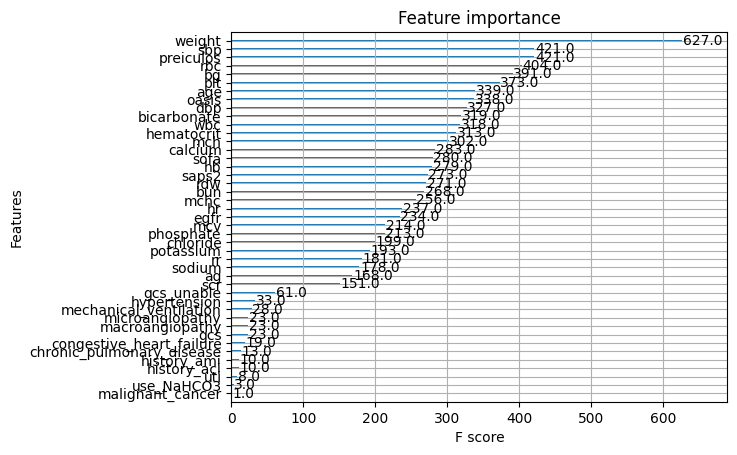

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

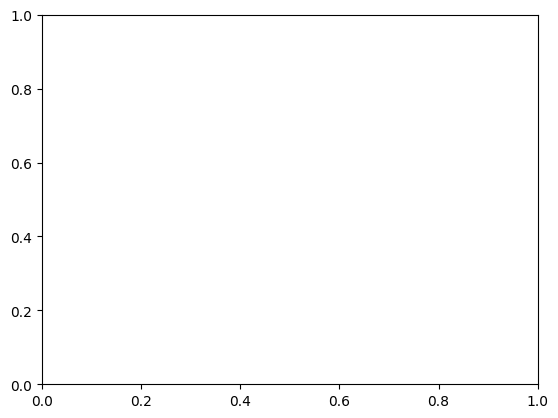

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66701


[1]	validation_0-logloss:0.66407


[2]	validation_0-logloss:0.66145


[3]	validation_0-logloss:0.65911


[4]	validation_0-logloss:0.65652


[5]	validation_0-logloss:0.65416


[6]	validation_0-logloss:0.65145


[7]	validation_0-logloss:0.64876


[8]	validation_0-logloss:0.64717


[9]	validation_0-logloss:0.64468


[10]	validation_0-logloss:0.64290


[11]	validation_0-logloss:0.64104


[12]	validation_0-logloss:0.63922


[13]	validation_0-logloss:0.63730


[14]	validation_0-logloss:0.63543


[15]	validation_0-logloss:0.63261


[16]	validation_0-logloss:0.63078


[17]	validation_0-logloss:0.62865


[18]	validation_0-logloss:0.62694


[19]	validation_0-logloss:0.62518


[20]	validation_0-logloss:0.62336


[21]	validation_0-logloss:0.62148


[22]	validation_0-logloss:0.61957


[23]	validation_0-logloss:0.61808


[24]	validation_0-logloss:0.61628


[25]	validation_0-logloss:0.61491


[26]	validation_0-logloss:0.61338


[27]	validation_0-logloss:0.61172


[28]	validation_0-logloss:0.61001


[29]	validation_0-logloss:0.60807


[30]	validation_0-logloss:0.60662


[31]	validation_0-logloss:0.60497


[32]	validation_0-logloss:0.60384


[33]	validation_0-logloss:0.60253


[34]	validation_0-logloss:0.60141


[35]	validation_0-logloss:0.60017


[36]	validation_0-logloss:0.59880


[37]	validation_0-logloss:0.59727


[38]	validation_0-logloss:0.59600


[39]	validation_0-logloss:0.59464


[40]	validation_0-logloss:0.59287


[41]	validation_0-logloss:0.59212


[42]	validation_0-logloss:0.59082


[43]	validation_0-logloss:0.58956


[44]	validation_0-logloss:0.58812


[45]	validation_0-logloss:0.58671


[46]	validation_0-logloss:0.58552


[47]	validation_0-logloss:0.58403


[48]	validation_0-logloss:0.58293


[49]	validation_0-logloss:0.58187


[50]	validation_0-logloss:0.58017


[51]	validation_0-logloss:0.57920


[52]	validation_0-logloss:0.57780


[53]	validation_0-logloss:0.57668


[54]	validation_0-logloss:0.57556


[55]	validation_0-logloss:0.57408


[56]	validation_0-logloss:0.57278


[57]	validation_0-logloss:0.57217


[58]	validation_0-logloss:0.57105


[59]	validation_0-logloss:0.57010


[60]	validation_0-logloss:0.56913


[61]	validation_0-logloss:0.56755


[62]	validation_0-logloss:0.56627


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:07:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[63]	validation_0-logloss:0.56541


[64]	validation_0-logloss:0.56502


[65]	validation_0-logloss:0.56410


[66]	validation_0-logloss:0.56274


[67]	validation_0-logloss:0.56233


[68]	validation_0-logloss:0.56105


[69]	validation_0-logloss:0.56038


[70]	validation_0-logloss:0.55924


[71]	validation_0-logloss:0.55837


[72]	validation_0-logloss:0.55750


[73]	validation_0-logloss:0.55668


[74]	validation_0-logloss:0.55519


[75]	validation_0-logloss:0.55435


[76]	validation_0-logloss:0.55369

[77]	validation_0-logloss:0.55278


[78]	validation_0-logloss:0.55169


[79]	validation_0-logloss:0.55070


[80]	validation_0-logloss:0.55030


[81]	validation_0-logloss:0.54916


[82]	validation_0-logloss:0.54856


[83]	validation_0-logloss:0.54795


[84]	validation_0-logloss:0.54740


[85]	validation_0-logloss:0.54613


[86]	validation_0-logloss:0.54540


[87]	validation_0-logloss:0.54444


[88]	validation_0-logloss:0.54387


[89]	validation_0-logloss:0.54321


[90]	validation_0-logloss:0.54239


[91]	validation_0-logloss:0.54219

[92]	validation_0-logloss:0.54176


[93]	validation_0-logloss:0.54116


[94]	validation_0-logloss:0.54053


[95]	validation_0-logloss:0.53993


[96]	validation_0-logloss:0.53965


[97]	validation_0-logloss:0.53943


[98]	validation_0-logloss:0.53856


[99]	validation_0-logloss:0.53827


[100]	validation_0-logloss:0.53769


[101]	validation_0-logloss:0.53734


[102]	validation_0-logloss:0.53636


[103]	validation_0-logloss:0.53596


[104]	validation_0-logloss:0.53519


[105]	validation_0-logloss:0.53412


[106]	validation_0-logloss:0.53371


[107]	validation_0-logloss:0.53291


[108]	validation_0-logloss:0.53207


[109]	validation_0-logloss:0.53132


[110]	validation_0-logloss:0.53078


[111]	validation_0-logloss:0.52987


[112]	validation_0-logloss:0.52958


[113]	validation_0-logloss:0.52865


[114]	validation_0-logloss:0.52812


[115]	validation_0-logloss:0.52782


[116]	validation_0-logloss:0.52757


[117]	validation_0-logloss:0.52727


[118]	validation_0-logloss:0.52685


[119]	validation_0-logloss:0.52634


[120]	validation_0-logloss:0.52560


[121]	validation_0-logloss:0.52497


[122]	validation_0-logloss:0.52501


[123]	validation_0-logloss:0.52476


[124]	validation_0-logloss:0.52451


[125]	validation_0-logloss:0.52392


[126]	validation_0-logloss:0.52348


[127]	validation_0-logloss:0.52308


[128]	validation_0-logloss:0.52290


[129]	validation_0-logloss:0.52224


[130]	validation_0-logloss:0.52185


[131]	validation_0-logloss:0.52159


[132]	validation_0-logloss:0.52097


[133]	validation_0-logloss:0.52067


[134]	validation_0-logloss:0.52045


[135]	validation_0-logloss:0.52036


[136]	validation_0-logloss:0.52000


[137]	validation_0-logloss:0.51936


[138]	validation_0-logloss:0.51865


[139]	validation_0-logloss:0.51777


[140]	validation_0-logloss:0.51751


[141]	validation_0-logloss:0.51698


[142]	validation_0-logloss:0.51686


[143]	validation_0-logloss:0.51641


[144]	validation_0-logloss:0.51632


[145]	validation_0-logloss:0.51613

[146]	validation_0-logloss:0.51537


[147]	validation_0-logloss:0.51483


[148]	validation_0-logloss:0.51442


[149]	validation_0-logloss:0.51423

[150]	validation_0-logloss:0.51392


[151]	validation_0-logloss:0.51383


[152]	validation_0-logloss:0.51362


[153]	validation_0-logloss:0.51287


[154]	validation_0-logloss:0.51248


[155]	validation_0-logloss:0.51216


[156]	validation_0-logloss:0.51184


[157]	validation_0-logloss:0.51158


[158]	validation_0-logloss:0.51094

[159]	validation_0-logloss:0.51076


[160]	validation_0-logloss:0.51056


[161]	validation_0-logloss:0.50993


[162]	validation_0-logloss:0.50981


[163]	validation_0-logloss:0.50925


[164]	validation_0-logloss:0.50887


[165]	validation_0-logloss:0.50846


[166]	validation_0-logloss:0.50803


[167]	validation_0-logloss:0.50792


[168]	validation_0-logloss:0.50783


[169]	validation_0-logloss:0.50761


[170]	validation_0-logloss:0.50729


[171]	validation_0-logloss:0.50737


[172]	validation_0-logloss:0.50707


[173]	validation_0-logloss:0.50738


[174]	validation_0-logloss:0.50713


[175]	validation_0-logloss:0.50690


[176]	validation_0-logloss:0.50682


[177]	validation_0-logloss:0.50633


[178]	validation_0-logloss:0.50587


[179]	validation_0-logloss:0.50577


[180]	validation_0-logloss:0.50554


[181]	validation_0-logloss:0.50529


[182]	validation_0-logloss:0.50491


[183]	validation_0-logloss:0.50428


[184]	validation_0-logloss:0.50362


[185]	validation_0-logloss:0.50374


[186]	validation_0-logloss:0.50353


[187]	validation_0-logloss:0.50325


[188]	validation_0-logloss:0.50299


[189]	validation_0-logloss:0.50262


[190]	validation_0-logloss:0.50242


[191]	validation_0-logloss:0.50245


[192]	validation_0-logloss:0.50241


[193]	validation_0-logloss:0.50204


[194]	validation_0-logloss:0.50166


[195]	validation_0-logloss:0.50150


[196]	validation_0-logloss:0.50128


[197]	validation_0-logloss:0.50081


[198]	validation_0-logloss:0.50084


[199]	validation_0-logloss:0.50073


[200]	validation_0-logloss:0.50052


[201]	validation_0-logloss:0.50044


[202]	validation_0-logloss:0.50035


[203]	validation_0-logloss:0.50001


[204]	validation_0-logloss:0.49968


[205]	validation_0-logloss:0.49992


[206]	validation_0-logloss:0.49970


[207]	validation_0-logloss:0.49944


[208]	validation_0-logloss:0.49909


[209]	validation_0-logloss:0.49889


[210]	validation_0-logloss:0.49851


[211]	validation_0-logloss:0.49851


[212]	validation_0-logloss:0.49816


[213]	validation_0-logloss:0.49797


[214]	validation_0-logloss:0.49795


[215]	validation_0-logloss:0.49736


[216]	validation_0-logloss:0.49704


[217]	validation_0-logloss:0.49705


[218]	validation_0-logloss:0.49658


[219]	validation_0-logloss:0.49643

[220]	validation_0-logloss:0.49647


[221]	validation_0-logloss:0.49628


[222]	validation_0-logloss:0.49566


[223]	validation_0-logloss:0.49557


[224]	validation_0-logloss:0.49564


[225]	validation_0-logloss:0.49541


[226]	validation_0-logloss:0.49476


[227]	validation_0-logloss:0.49468


[228]	validation_0-logloss:0.49441


[229]	validation_0-logloss:0.49390


[230]	validation_0-logloss:0.49408


[231]	validation_0-logloss:0.49424


[232]	validation_0-logloss:0.49437

[233]	validation_0-logloss:0.49438


[234]	validation_0-logloss:0.49412


[235]	validation_0-logloss:0.49420


[236]	validation_0-logloss:0.49375


[237]	validation_0-logloss:0.49355


[238]	validation_0-logloss:0.49341


[239]	validation_0-logloss:0.49320


[240]	validation_0-logloss:0.49272

[241]	validation_0-logloss:0.49228


[242]	validation_0-logloss:0.49234


[243]	validation_0-logloss:0.49223


[244]	validation_0-logloss:0.49214


[245]	validation_0-logloss:0.49185


[246]	validation_0-logloss:0.49182


[247]	validation_0-logloss:0.49167


[248]	validation_0-logloss:0.49156


[249]	validation_0-logloss:0.49171


[250]	validation_0-logloss:0.49188


[251]	validation_0-logloss:0.49199


[252]	validation_0-logloss:0.49177


[253]	validation_0-logloss:0.49179


[254]	validation_0-logloss:0.49192


[255]	validation_0-logloss:0.49212


[256]	validation_0-logloss:0.49183


[257]	validation_0-logloss:0.49167


[258]	validation_0-logloss:0.49180


[0]	validation_0-logloss:0.66750


[1]	validation_0-logloss:0.66494


[2]	validation_0-logloss:0.66276


[3]	validation_0-logloss:0.66066


[4]	validation_0-logloss:0.65839


[5]	validation_0-logloss:0.65590


[6]	validation_0-logloss:0.65399


[7]	validation_0-logloss:0.65150


[8]	validation_0-logloss:0.64979


[9]	validation_0-logloss:0.64801


[10]	validation_0-logloss:0.64603


[11]	validation_0-logloss:0.64462


[12]	validation_0-logloss:0.64281


[13]	validation_0-logloss:0.64085


[14]	validation_0-logloss:0.63878


[15]	validation_0-logloss:0.63665


[16]	validation_0-logloss:0.63516


[17]	validation_0-logloss:0.63346


[18]	validation_0-logloss:0.63164


[19]	validation_0-logloss:0.63047


[20]	validation_0-logloss:0.62856


[21]	validation_0-logloss:0.62692


[22]	validation_0-logloss:0.62527


[23]	validation_0-logloss:0.62378


[24]	validation_0-logloss:0.62210


[25]	validation_0-logloss:0.62104


[26]	validation_0-logloss:0.61942


[27]	validation_0-logloss:0.61774


[28]	validation_0-logloss:0.61598


[29]	validation_0-logloss:0.61461


[30]	validation_0-logloss:0.61341


[31]	validation_0-logloss:0.61216


[32]	validation_0-logloss:0.61059


[33]	validation_0-logloss:0.60919


[34]	validation_0-logloss:0.60770


[35]	validation_0-logloss:0.60663


[36]	validation_0-logloss:0.60491


[37]	validation_0-logloss:0.60337


[38]	validation_0-logloss:0.60167


[39]	validation_0-logloss:0.60000


[40]	validation_0-logloss:0.59851


[41]	validation_0-logloss:0.59706


[42]	validation_0-logloss:0.59578


[43]	validation_0-logloss:0.59498


[44]	validation_0-logloss:0.59332


[45]	validation_0-logloss:0.59213


[46]	validation_0-logloss:0.59144


[47]	validation_0-logloss:0.58992


[48]	validation_0-logloss:0.58850


[49]	validation_0-logloss:0.58710


[50]	validation_0-logloss:0.58579


[51]	validation_0-logloss:0.58483


[52]	validation_0-logloss:0.58370


[53]	validation_0-logloss:0.58265


[54]	validation_0-logloss:0.58172


[55]	validation_0-logloss:0.58079


[56]	validation_0-logloss:0.57962


[57]	validation_0-logloss:0.57877


[58]	validation_0-logloss:0.57774


[59]	validation_0-logloss:0.57676


[60]	validation_0-logloss:0.57601


[61]	validation_0-logloss:0.57547


[62]	validation_0-logloss:0.57435


[63]	validation_0-logloss:0.57340


[64]	validation_0-logloss:0.57240


[65]	validation_0-logloss:0.57099


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:08:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[66]	validation_0-logloss:0.57001


[67]	validation_0-logloss:0.56880


[68]	validation_0-logloss:0.56816


[69]	validation_0-logloss:0.56735


[70]	validation_0-logloss:0.56643


[71]	validation_0-logloss:0.56587


[72]	validation_0-logloss:0.56513


[73]	validation_0-logloss:0.56417


[74]	validation_0-logloss:0.56303


[75]	validation_0-logloss:0.56197

[76]	validation_0-logloss:0.56132


[77]	validation_0-logloss:0.56050

[78]	validation_0-logloss:0.55986


[79]	validation_0-logloss:0.55887


[80]	validation_0-logloss:0.55806


[81]	validation_0-logloss:0.55747


[82]	validation_0-logloss:0.55631


[83]	validation_0-logloss:0.55516


[84]	validation_0-logloss:0.55431


[85]	validation_0-logloss:0.55351


[86]	validation_0-logloss:0.55321


[87]	validation_0-logloss:0.55258


[88]	validation_0-logloss:0.55206


[89]	validation_0-logloss:0.55192


[90]	validation_0-logloss:0.55115


[91]	validation_0-logloss:0.55059


[92]	validation_0-logloss:0.54982


[93]	validation_0-logloss:0.54892


[94]	validation_0-logloss:0.54825


[95]	validation_0-logloss:0.54805


[96]	validation_0-logloss:0.54751


[97]	validation_0-logloss:0.54712


[98]	validation_0-logloss:0.54607


[99]	validation_0-logloss:0.54538


[100]	validation_0-logloss:0.54469


[101]	validation_0-logloss:0.54377


[102]	validation_0-logloss:0.54320


[103]	validation_0-logloss:0.54249


[104]	validation_0-logloss:0.54213


[105]	validation_0-logloss:0.54127


[106]	validation_0-logloss:0.54089


[107]	validation_0-logloss:0.54076


[108]	validation_0-logloss:0.54034


[109]	validation_0-logloss:0.53989


[110]	validation_0-logloss:0.53947


[111]	validation_0-logloss:0.53910


[112]	validation_0-logloss:0.53851


[113]	validation_0-logloss:0.53813


[114]	validation_0-logloss:0.53718


[115]	validation_0-logloss:0.53637


[116]	validation_0-logloss:0.53613


[117]	validation_0-logloss:0.53528


[118]	validation_0-logloss:0.53448


[119]	validation_0-logloss:0.53382


[120]	validation_0-logloss:0.53325


[121]	validation_0-logloss:0.53280


[122]	validation_0-logloss:0.53253


[123]	validation_0-logloss:0.53186


[124]	validation_0-logloss:0.53179


[125]	validation_0-logloss:0.53153


[126]	validation_0-logloss:0.53094


[127]	validation_0-logloss:0.53021


[128]	validation_0-logloss:0.52981


[129]	validation_0-logloss:0.52937


[130]	validation_0-logloss:0.52868


[131]	validation_0-logloss:0.52833


[132]	validation_0-logloss:0.52807


[133]	validation_0-logloss:0.52757


[134]	validation_0-logloss:0.52695


[135]	validation_0-logloss:0.52667


[136]	validation_0-logloss:0.52628


[137]	validation_0-logloss:0.52609


[138]	validation_0-logloss:0.52550


[139]	validation_0-logloss:0.52517


[140]	validation_0-logloss:0.52484


[141]	validation_0-logloss:0.52456


[142]	validation_0-logloss:0.52389


[143]	validation_0-logloss:0.52324


[144]	validation_0-logloss:0.52295


[145]	validation_0-logloss:0.52266


[146]	validation_0-logloss:0.52208


[147]	validation_0-logloss:0.52176


[148]	validation_0-logloss:0.52113


[149]	validation_0-logloss:0.52099


[150]	validation_0-logloss:0.52060


[151]	validation_0-logloss:0.52030


[152]	validation_0-logloss:0.52008


[153]	validation_0-logloss:0.51978


[154]	validation_0-logloss:0.51940


[155]	validation_0-logloss:0.51916


[156]	validation_0-logloss:0.51885


[157]	validation_0-logloss:0.51825


[158]	validation_0-logloss:0.51822


[159]	validation_0-logloss:0.51768


[160]	validation_0-logloss:0.51729


[161]	validation_0-logloss:0.51695


[162]	validation_0-logloss:0.51668


[163]	validation_0-logloss:0.51661


[164]	validation_0-logloss:0.51622


[165]	validation_0-logloss:0.51581


[166]	validation_0-logloss:0.51534


[167]	validation_0-logloss:0.51515


[168]	validation_0-logloss:0.51485


[169]	validation_0-logloss:0.51465


[170]	validation_0-logloss:0.51441


[171]	validation_0-logloss:0.51411


[172]	validation_0-logloss:0.51389


[173]	validation_0-logloss:0.51380


[174]	validation_0-logloss:0.51342


[175]	validation_0-logloss:0.51307

[176]	validation_0-logloss:0.51280


[177]	validation_0-logloss:0.51255


[178]	validation_0-logloss:0.51234


[179]	validation_0-logloss:0.51235


[180]	validation_0-logloss:0.51186


[181]	validation_0-logloss:0.51162


[182]	validation_0-logloss:0.51146


[183]	validation_0-logloss:0.51128

[184]	validation_0-logloss:0.51113


[185]	validation_0-logloss:0.51102


[186]	validation_0-logloss:0.51106


[187]	validation_0-logloss:0.51115


[188]	validation_0-logloss:0.51086


[189]	validation_0-logloss:0.51083


[190]	validation_0-logloss:0.51063


[191]	validation_0-logloss:0.51038


[192]	validation_0-logloss:0.51030


[193]	validation_0-logloss:0.50971


[194]	validation_0-logloss:0.50951


[195]	validation_0-logloss:0.50953


[196]	validation_0-logloss:0.50944


[197]	validation_0-logloss:0.50935


[198]	validation_0-logloss:0.50944


[199]	validation_0-logloss:0.50915


[200]	validation_0-logloss:0.50913


[201]	validation_0-logloss:0.50919


[202]	validation_0-logloss:0.50907


[203]	validation_0-logloss:0.50867


[204]	validation_0-logloss:0.50840

[205]	validation_0-logloss:0.50834


[206]	validation_0-logloss:0.50812


[207]	validation_0-logloss:0.50763

[208]	validation_0-logloss:0.50766


[209]	validation_0-logloss:0.50734


[210]	validation_0-logloss:0.50713


[211]	validation_0-logloss:0.50676


[212]	validation_0-logloss:0.50660


[213]	validation_0-logloss:0.50615


[214]	validation_0-logloss:0.50606


[215]	validation_0-logloss:0.50621


[216]	validation_0-logloss:0.50606


[217]	validation_0-logloss:0.50602


[218]	validation_0-logloss:0.50615


[219]	validation_0-logloss:0.50605


[220]	validation_0-logloss:0.50577


[221]	validation_0-logloss:0.50575


[222]	validation_0-logloss:0.50540


[223]	validation_0-logloss:0.50529


[224]	validation_0-logloss:0.50479


[225]	validation_0-logloss:0.50464


[226]	validation_0-logloss:0.50437


[227]	validation_0-logloss:0.50410


[228]	validation_0-logloss:0.50407


[229]	validation_0-logloss:0.50398


[230]	validation_0-logloss:0.50383


[231]	validation_0-logloss:0.50388


[232]	validation_0-logloss:0.50372


[233]	validation_0-logloss:0.50343


[234]	validation_0-logloss:0.50327


[235]	validation_0-logloss:0.50309


[236]	validation_0-logloss:0.50291


[237]	validation_0-logloss:0.50274


[238]	validation_0-logloss:0.50268


[239]	validation_0-logloss:0.50202


[240]	validation_0-logloss:0.50202


[241]	validation_0-logloss:0.50191


[242]	validation_0-logloss:0.50184


[243]	validation_0-logloss:0.50164


[244]	validation_0-logloss:0.50139


[245]	validation_0-logloss:0.50135


[246]	validation_0-logloss:0.50089


[247]	validation_0-logloss:0.50071


[248]	validation_0-logloss:0.50055


[249]	validation_0-logloss:0.50014


[250]	validation_0-logloss:0.50000


[251]	validation_0-logloss:0.49999

[252]	validation_0-logloss:0.49973


[253]	validation_0-logloss:0.49971


[254]	validation_0-logloss:0.49989


[255]	validation_0-logloss:0.50004


[256]	validation_0-logloss:0.49969


[257]	validation_0-logloss:0.49947


[258]	validation_0-logloss:0.49921


[259]	validation_0-logloss:0.49936


[260]	validation_0-logloss:0.49910

[261]	validation_0-logloss:0.49912


[262]	validation_0-logloss:0.49902


[263]	validation_0-logloss:0.49900


[264]	validation_0-logloss:0.49891


[265]	validation_0-logloss:0.49874


[266]	validation_0-logloss:0.49857


[267]	validation_0-logloss:0.49858


[268]	validation_0-logloss:0.49845


[269]	validation_0-logloss:0.49835


[270]	validation_0-logloss:0.49820


[271]	validation_0-logloss:0.49813


[272]	validation_0-logloss:0.49797


[273]	validation_0-logloss:0.49774


[274]	validation_0-logloss:0.49773


[275]	validation_0-logloss:0.49770


[276]	validation_0-logloss:0.49773


[277]	validation_0-logloss:0.49794


[278]	validation_0-logloss:0.49785


[279]	validation_0-logloss:0.49765


[280]	validation_0-logloss:0.49772


[281]	validation_0-logloss:0.49786


[282]	validation_0-logloss:0.49775


[283]	validation_0-logloss:0.49785


[284]	validation_0-logloss:0.49798


[285]	validation_0-logloss:0.49786


[286]	validation_0-logloss:0.49798


[287]	validation_0-logloss:0.49800


[288]	validation_0-logloss:0.49785


[289]	validation_0-logloss:0.49783

[0]	validation_0-logloss:0.66758


[1]	validation_0-logloss:0.66568


[2]	validation_0-logloss:0.66316


[3]	validation_0-logloss:0.66022


[4]	validation_0-logloss:0.65761


[5]	validation_0-logloss:0.65556


[6]	validation_0-logloss:0.65291


[7]	validation_0-logloss:0.65081


[8]	validation_0-logloss:0.64846


[9]	validation_0-logloss:0.64623


[10]	validation_0-logloss:0.64421


[11]	validation_0-logloss:0.64280


[12]	validation_0-logloss:0.64100


[13]	validation_0-logloss:0.63925


[14]	validation_0-logloss:0.63748


[15]	validation_0-logloss:0.63570


[16]	validation_0-logloss:0.63434


[17]	validation_0-logloss:0.63266


[18]	validation_0-logloss:0.63126


[19]	validation_0-logloss:0.62976


[20]	validation_0-logloss:0.62811


[21]	validation_0-logloss:0.62639


[22]	validation_0-logloss:0.62450


[23]	validation_0-logloss:0.62358


[24]	validation_0-logloss:0.62249


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:08:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-logloss:0.62051


[26]	validation_0-logloss:0.61890


[27]	validation_0-logloss:0.61726


[28]	validation_0-logloss:0.61582


[29]	validation_0-logloss:0.61404


[30]	validation_0-logloss:0.61238


[31]	validation_0-logloss:0.61127


[32]	validation_0-logloss:0.60940


[33]	validation_0-logloss:0.60801


[34]	validation_0-logloss:0.60663


[35]	validation_0-logloss:0.60562


[36]	validation_0-logloss:0.60403


[37]	validation_0-logloss:0.60315


[38]	validation_0-logloss:0.60238


[39]	validation_0-logloss:0.60122


[40]	validation_0-logloss:0.60012


[41]	validation_0-logloss:0.59874


[42]	validation_0-logloss:0.59715


[43]	validation_0-logloss:0.59560


[44]	validation_0-logloss:0.59376


[45]	validation_0-logloss:0.59290


[46]	validation_0-logloss:0.59176


[47]	validation_0-logloss:0.59060


[48]	validation_0-logloss:0.58976


[49]	validation_0-logloss:0.58858


[50]	validation_0-logloss:0.58710


[51]	validation_0-logloss:0.58614


[52]	validation_0-logloss:0.58532


[53]	validation_0-logloss:0.58445


[54]	validation_0-logloss:0.58383


[55]	validation_0-logloss:0.58266


[56]	validation_0-logloss:0.58160


[57]	validation_0-logloss:0.58068


[58]	validation_0-logloss:0.57963


[59]	validation_0-logloss:0.57852


[60]	validation_0-logloss:0.57735


[61]	validation_0-logloss:0.57616


[62]	validation_0-logloss:0.57509


[63]	validation_0-logloss:0.57390


[64]	validation_0-logloss:0.57320


[65]	validation_0-logloss:0.57210


[66]	validation_0-logloss:0.57116


[67]	validation_0-logloss:0.57024


[68]	validation_0-logloss:0.56976


[69]	validation_0-logloss:0.56903


[70]	validation_0-logloss:0.56801


[71]	validation_0-logloss:0.56780


[72]	validation_0-logloss:0.56647


[73]	validation_0-logloss:0.56512


[74]	validation_0-logloss:0.56408


[75]	validation_0-logloss:0.56361


[76]	validation_0-logloss:0.56292


[77]	validation_0-logloss:0.56233


[78]	validation_0-logloss:0.56166


[79]	validation_0-logloss:0.56088


[80]	validation_0-logloss:0.56038


[81]	validation_0-logloss:0.55945


[82]	validation_0-logloss:0.55870


[83]	validation_0-logloss:0.55788


[84]	validation_0-logloss:0.55700


[85]	validation_0-logloss:0.55591


[86]	validation_0-logloss:0.55511


[87]	validation_0-logloss:0.55455


[88]	validation_0-logloss:0.55354


[89]	validation_0-logloss:0.55282


[90]	validation_0-logloss:0.55247


[91]	validation_0-logloss:0.55213


[92]	validation_0-logloss:0.55149


[93]	validation_0-logloss:0.55118


[94]	validation_0-logloss:0.55025


[95]	validation_0-logloss:0.54965


[96]	validation_0-logloss:0.54920


[97]	validation_0-logloss:0.54902


[98]	validation_0-logloss:0.54869


[99]	validation_0-logloss:0.54850


[100]	validation_0-logloss:0.54844


[101]	validation_0-logloss:0.54800


[102]	validation_0-logloss:0.54739


[103]	validation_0-logloss:0.54650


[104]	validation_0-logloss:0.54604


[105]	validation_0-logloss:0.54626


[106]	validation_0-logloss:0.54567


[107]	validation_0-logloss:0.54513


[108]	validation_0-logloss:0.54495


[109]	validation_0-logloss:0.54460


[110]	validation_0-logloss:0.54411


[111]	validation_0-logloss:0.54402


[112]	validation_0-logloss:0.54337


[113]	validation_0-logloss:0.54324


[114]	validation_0-logloss:0.54322


[115]	validation_0-logloss:0.54289


[116]	validation_0-logloss:0.54247


[117]	validation_0-logloss:0.54240


[118]	validation_0-logloss:0.54211


[119]	validation_0-logloss:0.54158


[120]	validation_0-logloss:0.54126


[121]	validation_0-logloss:0.54082


[122]	validation_0-logloss:0.54027


[123]	validation_0-logloss:0.53950


[124]	validation_0-logloss:0.53951


[125]	validation_0-logloss:0.53894


[126]	validation_0-logloss:0.53856


[127]	validation_0-logloss:0.53872


[128]	validation_0-logloss:0.53848


[129]	validation_0-logloss:0.53820


[130]	validation_0-logloss:0.53831


[131]	validation_0-logloss:0.53800


[132]	validation_0-logloss:0.53831


[133]	validation_0-logloss:0.53792


[134]	validation_0-logloss:0.53817


[135]	validation_0-logloss:0.53753


[136]	validation_0-logloss:0.53732


[137]	validation_0-logloss:0.53667


[138]	validation_0-logloss:0.53617


[139]	validation_0-logloss:0.53590


[140]	validation_0-logloss:0.53562


[141]	validation_0-logloss:0.53540


[142]	validation_0-logloss:0.53494


[143]	validation_0-logloss:0.53437


[144]	validation_0-logloss:0.53388


[145]	validation_0-logloss:0.53392


[146]	validation_0-logloss:0.53373


[147]	validation_0-logloss:0.53316


[148]	validation_0-logloss:0.53249


[149]	validation_0-logloss:0.53218


[150]	validation_0-logloss:0.53223


[151]	validation_0-logloss:0.53218


[152]	validation_0-logloss:0.53189


[153]	validation_0-logloss:0.53184


[154]	validation_0-logloss:0.53178


[155]	validation_0-logloss:0.53162


[156]	validation_0-logloss:0.53195


[157]	validation_0-logloss:0.53206


[158]	validation_0-logloss:0.53169


[159]	validation_0-logloss:0.53138


[160]	validation_0-logloss:0.53130


[161]	validation_0-logloss:0.53139


[162]	validation_0-logloss:0.53132


[163]	validation_0-logloss:0.53116


[164]	validation_0-logloss:0.53080


[165]	validation_0-logloss:0.53011

[166]	validation_0-logloss:0.52979


[167]	validation_0-logloss:0.52945


[168]	validation_0-logloss:0.52909

[169]	validation_0-logloss:0.52883


[170]	validation_0-logloss:0.52900


[171]	validation_0-logloss:0.52900

[172]	validation_0-logloss:0.52888


[173]	validation_0-logloss:0.52894


[174]	validation_0-logloss:0.52913

[175]	validation_0-logloss:0.52938


[176]	validation_0-logloss:0.52954


[177]	validation_0-logloss:0.52954


[178]	validation_0-logloss:0.52941


[0]	validation_0-logloss:0.66765


[1]	validation_0-logloss:0.66497


[2]	validation_0-logloss:0.66222


[3]	validation_0-logloss:0.66023


[4]	validation_0-logloss:0.65838


[5]	validation_0-logloss:0.65589


[6]	validation_0-logloss:0.65352


[7]	validation_0-logloss:0.65073


[8]	validation_0-logloss:0.64914


[9]	validation_0-logloss:0.64738


[10]	validation_0-logloss:0.64549


[11]	validation_0-logloss:0.64369


[12]	validation_0-logloss:0.64156


[13]	validation_0-logloss:0.63964


[14]	validation_0-logloss:0.63765


[15]	validation_0-logloss:0.63645


[16]	validation_0-logloss:0.63416


[17]	validation_0-logloss:0.63219


[18]	validation_0-logloss:0.63106


[19]	validation_0-logloss:0.62905


[20]	validation_0-logloss:0.62748


[21]	validation_0-logloss:0.62606


[22]	validation_0-logloss:0.62451


[23]	validation_0-logloss:0.62340


[24]	validation_0-logloss:0.62158


[25]	validation_0-logloss:0.61959


[26]	validation_0-logloss:0.61819


[27]	validation_0-logloss:0.61657


[28]	validation_0-logloss:0.61465


[29]	validation_0-logloss:0.61316


[30]	validation_0-logloss:0.61162


[31]	validation_0-logloss:0.60966


[32]	validation_0-logloss:0.60831


[33]	validation_0-logloss:0.60758


[34]	validation_0-logloss:0.60596


[35]	validation_0-logloss:0.60480


[36]	validation_0-logloss:0.60320


[37]	validation_0-logloss:0.60160


[38]	validation_0-logloss:0.60066


[39]	validation_0-logloss:0.59948


[40]	validation_0-logloss:0.59836


[41]	validation_0-logloss:0.59660


[42]	validation_0-logloss:0.59464


[43]	validation_0-logloss:0.59331


[44]	validation_0-logloss:0.59220


[45]	validation_0-logloss:0.59090


[46]	validation_0-logloss:0.58961


[47]	validation_0-logloss:0.58849


[48]	validation_0-logloss:0.58750


[49]	validation_0-logloss:0.58620


[50]	validation_0-logloss:0.58492


[51]	validation_0-logloss:0.58376


[52]	validation_0-logloss:0.58277


[53]	validation_0-logloss:0.58196


[54]	validation_0-logloss:0.58121


[55]	validation_0-logloss:0.57947


[56]	validation_0-logloss:0.57806


[57]	validation_0-logloss:0.57724


[58]	validation_0-logloss:0.57598


[59]	validation_0-logloss:0.57513


[60]	validation_0-logloss:0.57423


[61]	validation_0-logloss:0.57343


[62]	validation_0-logloss:0.57291


[63]	validation_0-logloss:0.57221


[64]	validation_0-logloss:0.57161


[65]	validation_0-logloss:0.57032


[66]	validation_0-logloss:0.57019


[67]	validation_0-logloss:0.56923


[68]	validation_0-logloss:0.56848


[69]	validation_0-logloss:0.56778


[70]	validation_0-logloss:0.56685


[71]	validation_0-logloss:0.56612


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:08:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[72]	validation_0-logloss:0.56504


[73]	validation_0-logloss:0.56428


[74]	validation_0-logloss:0.56314


[75]	validation_0-logloss:0.56184


[76]	validation_0-logloss:0.56114


[77]	validation_0-logloss:0.56061


[78]	validation_0-logloss:0.55924

[79]	validation_0-logloss:0.55851


[80]	validation_0-logloss:0.55763


[81]	validation_0-logloss:0.55702

[82]	validation_0-logloss:0.55625

[83]	validation_0-logloss:0.55533


[84]	validation_0-logloss:0.55468


[85]	validation_0-logloss:0.55415


[86]	validation_0-logloss:0.55322


[87]	validation_0-logloss:0.55219


[88]	validation_0-logloss:0.55124


[89]	validation_0-logloss:0.55051


[90]	validation_0-logloss:0.54986


[91]	validation_0-logloss:0.54947


[92]	validation_0-logloss:0.54863


[93]	validation_0-logloss:0.54805


[94]	validation_0-logloss:0.54716


[95]	validation_0-logloss:0.54645


[96]	validation_0-logloss:0.54596


[97]	validation_0-logloss:0.54564


[98]	validation_0-logloss:0.54534


[99]	validation_0-logloss:0.54488


[100]	validation_0-logloss:0.54404


[101]	validation_0-logloss:0.54301


[102]	validation_0-logloss:0.54220


[103]	validation_0-logloss:0.54174


[104]	validation_0-logloss:0.54066


[105]	validation_0-logloss:0.54004


[106]	validation_0-logloss:0.53980


[107]	validation_0-logloss:0.53934


[108]	validation_0-logloss:0.53863


[109]	validation_0-logloss:0.53822


[110]	validation_0-logloss:0.53760


[111]	validation_0-logloss:0.53694


[112]	validation_0-logloss:0.53624


[113]	validation_0-logloss:0.53618


[114]	validation_0-logloss:0.53563


[115]	validation_0-logloss:0.53544


[116]	validation_0-logloss:0.53450


[117]	validation_0-logloss:0.53418


[118]	validation_0-logloss:0.53363


[119]	validation_0-logloss:0.53301


[120]	validation_0-logloss:0.53270


[121]	validation_0-logloss:0.53204


[122]	validation_0-logloss:0.53170


[123]	validation_0-logloss:0.53133


[124]	validation_0-logloss:0.53070


[125]	validation_0-logloss:0.53041


[126]	validation_0-logloss:0.52983


[127]	validation_0-logloss:0.52978


[128]	validation_0-logloss:0.52948


[129]	validation_0-logloss:0.52907


[130]	validation_0-logloss:0.52869


[131]	validation_0-logloss:0.52843


[132]	validation_0-logloss:0.52853


[133]	validation_0-logloss:0.52799


[134]	validation_0-logloss:0.52794

[135]	validation_0-logloss:0.52802


[136]	validation_0-logloss:0.52784


[137]	validation_0-logloss:0.52777


[138]	validation_0-logloss:0.52728


[139]	validation_0-logloss:0.52716


[140]	validation_0-logloss:0.52670


[141]	validation_0-logloss:0.52615


[142]	validation_0-logloss:0.52577


[143]	validation_0-logloss:0.52526


[144]	validation_0-logloss:0.52515


[145]	validation_0-logloss:0.52456


[146]	validation_0-logloss:0.52428


[147]	validation_0-logloss:0.52406


[148]	validation_0-logloss:0.52386

[149]	validation_0-logloss:0.52365

[150]	validation_0-logloss:0.52319


[151]	validation_0-logloss:0.52331


[152]	validation_0-logloss:0.52315


[153]	validation_0-logloss:0.52299


[154]	validation_0-logloss:0.52250


[155]	validation_0-logloss:0.52210


[156]	validation_0-logloss:0.52199


[157]	validation_0-logloss:0.52187


[158]	validation_0-logloss:0.52160

[159]	validation_0-logloss:0.52107

[160]	validation_0-logloss:0.52058


[161]	validation_0-logloss:0.52015


[162]	validation_0-logloss:0.51953


[163]	validation_0-logloss:0.51921


[164]	validation_0-logloss:0.51916


[165]	validation_0-logloss:0.51923


[166]	validation_0-logloss:0.51894


[167]	validation_0-logloss:0.51865


[168]	validation_0-logloss:0.51873


[169]	validation_0-logloss:0.51848


[170]	validation_0-logloss:0.51828


[171]	validation_0-logloss:0.51796


[172]	validation_0-logloss:0.51803


[173]	validation_0-logloss:0.51751


[174]	validation_0-logloss:0.51731


[175]	validation_0-logloss:0.51682


[176]	validation_0-logloss:0.51661


[177]	validation_0-logloss:0.51643


[178]	validation_0-logloss:0.51598


[179]	validation_0-logloss:0.51555


[180]	validation_0-logloss:0.51531


[181]	validation_0-logloss:0.51499


[182]	validation_0-logloss:0.51444


[183]	validation_0-logloss:0.51433


[184]	validation_0-logloss:0.51395


[185]	validation_0-logloss:0.51363


[186]	validation_0-logloss:0.51344


[187]	validation_0-logloss:0.51330


[188]	validation_0-logloss:0.51344


[189]	validation_0-logloss:0.51327


[190]	validation_0-logloss:0.51300


[191]	validation_0-logloss:0.51283


[192]	validation_0-logloss:0.51256


[193]	validation_0-logloss:0.51232


[194]	validation_0-logloss:0.51195


[195]	validation_0-logloss:0.51160


[196]	validation_0-logloss:0.51150


[197]	validation_0-logloss:0.51154


[198]	validation_0-logloss:0.51123


[199]	validation_0-logloss:0.51138


[200]	validation_0-logloss:0.51136


[201]	validation_0-logloss:0.51121


[202]	validation_0-logloss:0.51060


[203]	validation_0-logloss:0.51078


[204]	validation_0-logloss:0.51055


[205]	validation_0-logloss:0.51054


[206]	validation_0-logloss:0.51052


[207]	validation_0-logloss:0.51057


[208]	validation_0-logloss:0.51058


[209]	validation_0-logloss:0.51031


[210]	validation_0-logloss:0.50979


[211]	validation_0-logloss:0.50990


[212]	validation_0-logloss:0.50959


[213]	validation_0-logloss:0.50935


[214]	validation_0-logloss:0.50913


[215]	validation_0-logloss:0.50901


[216]	validation_0-logloss:0.50884


[217]	validation_0-logloss:0.50880


[218]	validation_0-logloss:0.50870


[219]	validation_0-logloss:0.50849


[220]	validation_0-logloss:0.50837


[221]	validation_0-logloss:0.50846


[222]	validation_0-logloss:0.50861


[223]	validation_0-logloss:0.50865


[224]	validation_0-logloss:0.50877


[225]	validation_0-logloss:0.50869

[226]	validation_0-logloss:0.50886

[227]	validation_0-logloss:0.50866


[228]	validation_0-logloss:0.50828


[229]	validation_0-logloss:0.50835


[230]	validation_0-logloss:0.50852


[231]	validation_0-logloss:0.50829


[232]	validation_0-logloss:0.50802


[233]	validation_0-logloss:0.50776


[234]	validation_0-logloss:0.50779


[235]	validation_0-logloss:0.50783

[236]	validation_0-logloss:0.50824


[237]	validation_0-logloss:0.50799


[238]	validation_0-logloss:0.50804


[239]	validation_0-logloss:0.50820


[240]	validation_0-logloss:0.50821


[241]	validation_0-logloss:0.50792


[242]	validation_0-logloss:0.50752


[243]	validation_0-logloss:0.50782

[244]	validation_0-logloss:0.50768


[245]	validation_0-logloss:0.50765


[246]	validation_0-logloss:0.50756

[247]	validation_0-logloss:0.50740


[248]	validation_0-logloss:0.50744


[249]	validation_0-logloss:0.50742


[250]	validation_0-logloss:0.50733


[251]	validation_0-logloss:0.50736


[252]	validation_0-logloss:0.50725


[253]	validation_0-logloss:0.50717


[254]	validation_0-logloss:0.50713


[255]	validation_0-logloss:0.50705


[256]	validation_0-logloss:0.50694


[257]	validation_0-logloss:0.50695


[258]	validation_0-logloss:0.50702


[259]	validation_0-logloss:0.50697


[260]	validation_0-logloss:0.50665


[261]	validation_0-logloss:0.50648


[262]	validation_0-logloss:0.50652


[263]	validation_0-logloss:0.50653


[264]	validation_0-logloss:0.50646


[265]	validation_0-logloss:0.50682


[266]	validation_0-logloss:0.50679

[267]	validation_0-logloss:0.50691


[268]	validation_0-logloss:0.50692


[269]	validation_0-logloss:0.50666


[270]	validation_0-logloss:0.50663


[271]	validation_0-logloss:0.50662


[272]	validation_0-logloss:0.50668


[273]	validation_0-logloss:0.50687


[274]	validation_0-logloss:0.50660


[0]	validation_0-logloss:0.66778


[1]	validation_0-logloss:0.66564


[2]	validation_0-logloss:0.66308


[3]	validation_0-logloss:0.66095


[4]	validation_0-logloss:0.65934


[5]	validation_0-logloss:0.65745


[6]	validation_0-logloss:0.65525


[7]	validation_0-logloss:0.65356


[8]	validation_0-logloss:0.65167


[9]	validation_0-logloss:0.64965


[10]	validation_0-logloss:0.64773


[11]	validation_0-logloss:0.64652


[12]	validation_0-logloss:0.64453


[13]	validation_0-logloss:0.64251


[14]	validation_0-logloss:0.64015


[15]	validation_0-logloss:0.63808


[16]	validation_0-logloss:0.63658


[17]	validation_0-logloss:0.63507


[18]	validation_0-logloss:0.63326


[19]	validation_0-logloss:0.63138


[20]	validation_0-logloss:0.62985


[21]	validation_0-logloss:0.62780


[22]	validation_0-logloss:0.62582


[23]	validation_0-logloss:0.62369


[24]	validation_0-logloss:0.62255


[25]	validation_0-logloss:0.62090


[26]	validation_0-logloss:0.61962


[27]	validation_0-logloss:0.61809


[28]	validation_0-logloss:0.61657


[29]	validation_0-logloss:0.61519


[30]	validation_0-logloss:0.61376


[31]	validation_0-logloss:0.61216


[32]	validation_0-logloss:0.61067


[33]	validation_0-logloss:0.60928


[34]	validation_0-logloss:0.60803


[35]	validation_0-logloss:0.60707


[36]	validation_0-logloss:0.60558


[37]	validation_0-logloss:0.60452


[38]	validation_0-logloss:0.60292


[39]	validation_0-logloss:0.60134


[40]	validation_0-logloss:0.60011


[41]	validation_0-logloss:0.59890


[42]	validation_0-logloss:0.59786


[43]	validation_0-logloss:0.59636


[44]	validation_0-logloss:0.59500


[45]	validation_0-logloss:0.59392


[46]	validation_0-logloss:0.59233


[47]	validation_0-logloss:0.59090


[48]	validation_0-logloss:0.58999


[49]	validation_0-logloss:0.58882


[50]	validation_0-logloss:0.58776


[51]	validation_0-logloss:0.58650


[52]	validation_0-logloss:0.58569


[53]	validation_0-logloss:0.58501


[54]	validation_0-logloss:0.58406


[55]	validation_0-logloss:0.58277


[56]	validation_0-logloss:0.58159


[57]	validation_0-logloss:0.58038


[58]	validation_0-logloss:0.57996


[59]	validation_0-logloss:0.57894


[60]	validation_0-logloss:0.57813


[61]	validation_0-logloss:0.57704


[62]	validation_0-logloss:0.57627


[63]	validation_0-logloss:0.57525


[64]	validation_0-logloss:0.57440


[65]	validation_0-logloss:0.57384


[66]	validation_0-logloss:0.57337


[67]	validation_0-logloss:0.57250


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:09:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[68]	validation_0-logloss:0.57143


[69]	validation_0-logloss:0.57022


[70]	validation_0-logloss:0.56961


[71]	validation_0-logloss:0.56898


[72]	validation_0-logloss:0.56801


[73]	validation_0-logloss:0.56683


[74]	validation_0-logloss:0.56561


[75]	validation_0-logloss:0.56516


[76]	validation_0-logloss:0.56470


[77]	validation_0-logloss:0.56421


[78]	validation_0-logloss:0.56316


[79]	validation_0-logloss:0.56236


[80]	validation_0-logloss:0.56193


[81]	validation_0-logloss:0.56132


[82]	validation_0-logloss:0.56039


[83]	validation_0-logloss:0.55978


[84]	validation_0-logloss:0.55910


[85]	validation_0-logloss:0.55837


[86]	validation_0-logloss:0.55780


[87]	validation_0-logloss:0.55696


[88]	validation_0-logloss:0.55635


[89]	validation_0-logloss:0.55536


[90]	validation_0-logloss:0.55480


[91]	validation_0-logloss:0.55429


[92]	validation_0-logloss:0.55407


[93]	validation_0-logloss:0.55324


[94]	validation_0-logloss:0.55291


[95]	validation_0-logloss:0.55266


[96]	validation_0-logloss:0.55171


[97]	validation_0-logloss:0.55100


[98]	validation_0-logloss:0.54967


[99]	validation_0-logloss:0.54926


[100]	validation_0-logloss:0.54872


[101]	validation_0-logloss:0.54767


[102]	validation_0-logloss:0.54768


[103]	validation_0-logloss:0.54728


[104]	validation_0-logloss:0.54637


[105]	validation_0-logloss:0.54556


[106]	validation_0-logloss:0.54489


[107]	validation_0-logloss:0.54430


[108]	validation_0-logloss:0.54364


[109]	validation_0-logloss:0.54308


[110]	validation_0-logloss:0.54224


[111]	validation_0-logloss:0.54150


[112]	validation_0-logloss:0.54056


[113]	validation_0-logloss:0.54000


[114]	validation_0-logloss:0.53931


[115]	validation_0-logloss:0.53893


[116]	validation_0-logloss:0.53852

[117]	validation_0-logloss:0.53824


[118]	validation_0-logloss:0.53788


[119]	validation_0-logloss:0.53748


[120]	validation_0-logloss:0.53718


[121]	validation_0-logloss:0.53721


[122]	validation_0-logloss:0.53654


[123]	validation_0-logloss:0.53586


[124]	validation_0-logloss:0.53519


[125]	validation_0-logloss:0.53447


[126]	validation_0-logloss:0.53417

[127]	validation_0-logloss:0.53389


[128]	validation_0-logloss:0.53329


[129]	validation_0-logloss:0.53289


[130]	validation_0-logloss:0.53242


[131]	validation_0-logloss:0.53197


[132]	validation_0-logloss:0.53141


[133]	validation_0-logloss:0.53149


[134]	validation_0-logloss:0.53122


[135]	validation_0-logloss:0.53049


[136]	validation_0-logloss:0.53009


[137]	validation_0-logloss:0.52994


[138]	validation_0-logloss:0.52902


[139]	validation_0-logloss:0.52875


[140]	validation_0-logloss:0.52826


[141]	validation_0-logloss:0.52783


[142]	validation_0-logloss:0.52785


[143]	validation_0-logloss:0.52766


[144]	validation_0-logloss:0.52744


[145]	validation_0-logloss:0.52711


[146]	validation_0-logloss:0.52707


[147]	validation_0-logloss:0.52671


[148]	validation_0-logloss:0.52689


[149]	validation_0-logloss:0.52651

[150]	validation_0-logloss:0.52614

[151]	validation_0-logloss:0.52614


[152]	validation_0-logloss:0.52583


[153]	validation_0-logloss:0.52573


[154]	validation_0-logloss:0.52497


[155]	validation_0-logloss:0.52452


[156]	validation_0-logloss:0.52420


[157]	validation_0-logloss:0.52409


[158]	validation_0-logloss:0.52397

[159]	validation_0-logloss:0.52355

[160]	validation_0-logloss:0.52317


[161]	validation_0-logloss:0.52314


[162]	validation_0-logloss:0.52308

[163]	validation_0-logloss:0.52285

[164]	validation_0-logloss:0.52249


[165]	validation_0-logloss:0.52218


[166]	validation_0-logloss:0.52193


[167]	validation_0-logloss:0.52164

[168]	validation_0-logloss:0.52130

[169]	validation_0-logloss:0.52098


[170]	validation_0-logloss:0.52099


[171]	validation_0-logloss:0.52093

[172]	validation_0-logloss:0.52074

[173]	validation_0-logloss:0.52055


[174]	validation_0-logloss:0.52035


[175]	validation_0-logloss:0.52019


[176]	validation_0-logloss:0.52044


[177]	validation_0-logloss:0.52023


[178]	validation_0-logloss:0.51993


[179]	validation_0-logloss:0.51970


[180]	validation_0-logloss:0.51937

[181]	validation_0-logloss:0.51952


[182]	validation_0-logloss:0.51922


[183]	validation_0-logloss:0.51877


[184]	validation_0-logloss:0.51849


[185]	validation_0-logloss:0.51855


[186]	validation_0-logloss:0.51842


[187]	validation_0-logloss:0.51812


[188]	validation_0-logloss:0.51820


[189]	validation_0-logloss:0.51835


[190]	validation_0-logloss:0.51816


[191]	validation_0-logloss:0.51810


[192]	validation_0-logloss:0.51815


[193]	validation_0-logloss:0.51802


[194]	validation_0-logloss:0.51778


[195]	validation_0-logloss:0.51773


[196]	validation_0-logloss:0.51744


[197]	validation_0-logloss:0.51735


[198]	validation_0-logloss:0.51694


[199]	validation_0-logloss:0.51663


[200]	validation_0-logloss:0.51661


[201]	validation_0-logloss:0.51641


[202]	validation_0-logloss:0.51583


[203]	validation_0-logloss:0.51585


[204]	validation_0-logloss:0.51585


[205]	validation_0-logloss:0.51562


[206]	validation_0-logloss:0.51557


[207]	validation_0-logloss:0.51558


[208]	validation_0-logloss:0.51555


[209]	validation_0-logloss:0.51527


[210]	validation_0-logloss:0.51539


[211]	validation_0-logloss:0.51498


[212]	validation_0-logloss:0.51476


[213]	validation_0-logloss:0.51477


[214]	validation_0-logloss:0.51452


[215]	validation_0-logloss:0.51464


[216]	validation_0-logloss:0.51436


[217]	validation_0-logloss:0.51454


[218]	validation_0-logloss:0.51453


[219]	validation_0-logloss:0.51450


[220]	validation_0-logloss:0.51444


[221]	validation_0-logloss:0.51446


[222]	validation_0-logloss:0.51451


[223]	validation_0-logloss:0.51448


[224]	validation_0-logloss:0.51415


[225]	validation_0-logloss:0.51366


[226]	validation_0-logloss:0.51346


[227]	validation_0-logloss:0.51352


[228]	validation_0-logloss:0.51370


[229]	validation_0-logloss:0.51338


[230]	validation_0-logloss:0.51321


[231]	validation_0-logloss:0.51261


[232]	validation_0-logloss:0.51242


[233]	validation_0-logloss:0.51207


[234]	validation_0-logloss:0.51211


[235]	validation_0-logloss:0.51225


[236]	validation_0-logloss:0.51250


[237]	validation_0-logloss:0.51223


[238]	validation_0-logloss:0.51248


[239]	validation_0-logloss:0.51208


[240]	validation_0-logloss:0.51227


[241]	validation_0-logloss:0.51227


[242]	validation_0-logloss:0.51228


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.8050270218995881
Average Accuracy: 0.7387983951167656
Average Precision: 0.7033481042547858
Average Recall: 0.5887122060470324
